In [33]:
# Imports
import cv2
import glob
import os.path
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np

from scipy.ndimage.measurements import label

from skimage.feature import hog
from skimage import color, exposure
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import features as F
import pipeline as p
import cars as c

# pipeline config
p.OVERLAP_RATIO = 0.9
p.PROBABILITY_THRESHOLD = 0.9
p.HEATMAP_THRESHOLD = 1
c.FRAME_COUNT_THRESHOLD = 6

%matplotlib inline


In [2]:
# Load Data and Feature engineering.

def LoadData(imagePath):
    images = glob.glob(imagePath)
    data = []

    for image in images:
        data.append(image)
    return data

carTrainDataPath = "./data/vehicles/*/*.png"
carTestDataPath = "./data/vehicles/*/test/*.png"

carsTrain = LoadData(carTrainDataPath)
carsTest = LoadData(carTestDataPath)

notCarPath = "./data/non-vehicles/*/*.png"
notCars = LoadData(notCarPath)

f = F.Features()

carTrainData_features = f.extract_features(carsTrain, color_space='YCrCb')
carTestData_features = f.extract_features(carsTest, color_space='YCrCb')
allcar_features = carTrainData_features + carTestData_features

notcar_features = f.extract_features(notCars, color_space='YCrCb')
rand_state = np.random.randint(0, 100)
notcar_features_train, notcar_features_test = train_test_split(notcar_features, train_size = 0.78, random_state=rand_state)

# Prepare Features.
print("Number of vehicles images: ", len(carTrainData_features), " ", len(carTestData_features), " ", len(allcar_features))
print("Number of non-vehicles images: ", len(notcar_features_train), " ", len(notcar_features_test), " ", len(notcar_features))



Number of vehicles images:  6824   1968   8792
Number of non-vehicles images:  6995   1973   8968


In [3]:
# Train and Save Classifier

# Create an array stack of feature vectors
X = np.vstack((allcar_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)


# Apply the scaler to X
carTrainData_features = X_scaler.transform(carTrainData_features)
carTestData_features = X_scaler.transform(carTestData_features)
notcar_features_train = X_scaler.transform(notcar_features_train)
notcar_features_test = X_scaler.transform(notcar_features_test)

X_train = np.vstack((carTrainData_features, notcar_features_train)).astype(np.float64)                        
y_train = np.hstack((np.ones(len(carTrainData_features)), np.zeros(len(notcar_features_train))))

X_test = np.vstack((carTestData_features, notcar_features_test)).astype(np.float64)                        
y_test = np.hstack((np.ones(len(carTestData_features)), np.zeros(len(notcar_features_test))))

rand_state = np.random.randint(0, 100)
X_train, y_train = shuffle(X_train, y_train, random_state=0)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
clf = CalibratedClassifierCV(svc)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
print('Train Accuracy of SVC = ', round(clf.score(X_train, y_train), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print('with probability: ', clf.predict_proba(X_test[0:n_predict]))

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# Save model & scaler
print("Saving models...")
joblib.dump(svc, './models/classifier.pkl')
joblib.dump(clf, './models/calibrated.pkl')
joblib.dump(X_scaler, './models/scaler.pkl')
print("Done!")

Feature vector length: 5388
32.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9817
Train Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
with probability:  [[  2.55294736e-08   9.99999974e-01]
 [  8.63656095e-04   9.99136344e-01]
 [  1.30768900e-05   9.99986923e-01]
 [  1.75083762e-05   9.99982492e-01]
 [  2.23734889e-05   9.99977627e-01]
 [  8.38148648e-07   9.99999162e-01]
 [  4.02010124e-04   9.99597990e-01]
 [  8.34623107e-05   9.99916538e-01]
 [  1.39043578e-04   9.99860956e-01]
 [  3.21352060e-06   9.99996786e-01]]
0.00378 Seconds to predict 10 labels with SVC
Saving models...
Done!


In [2]:
# Load Models

# Load the classifier model
svc = joblib.load('./models/classifier.pkl')
clf = joblib.load('./models/calibrated.pkl')

# Load the standard scalar model
X_scaler = joblib.load('./models/scaler.pkl')

max_val 1.0
max_val 0.992157


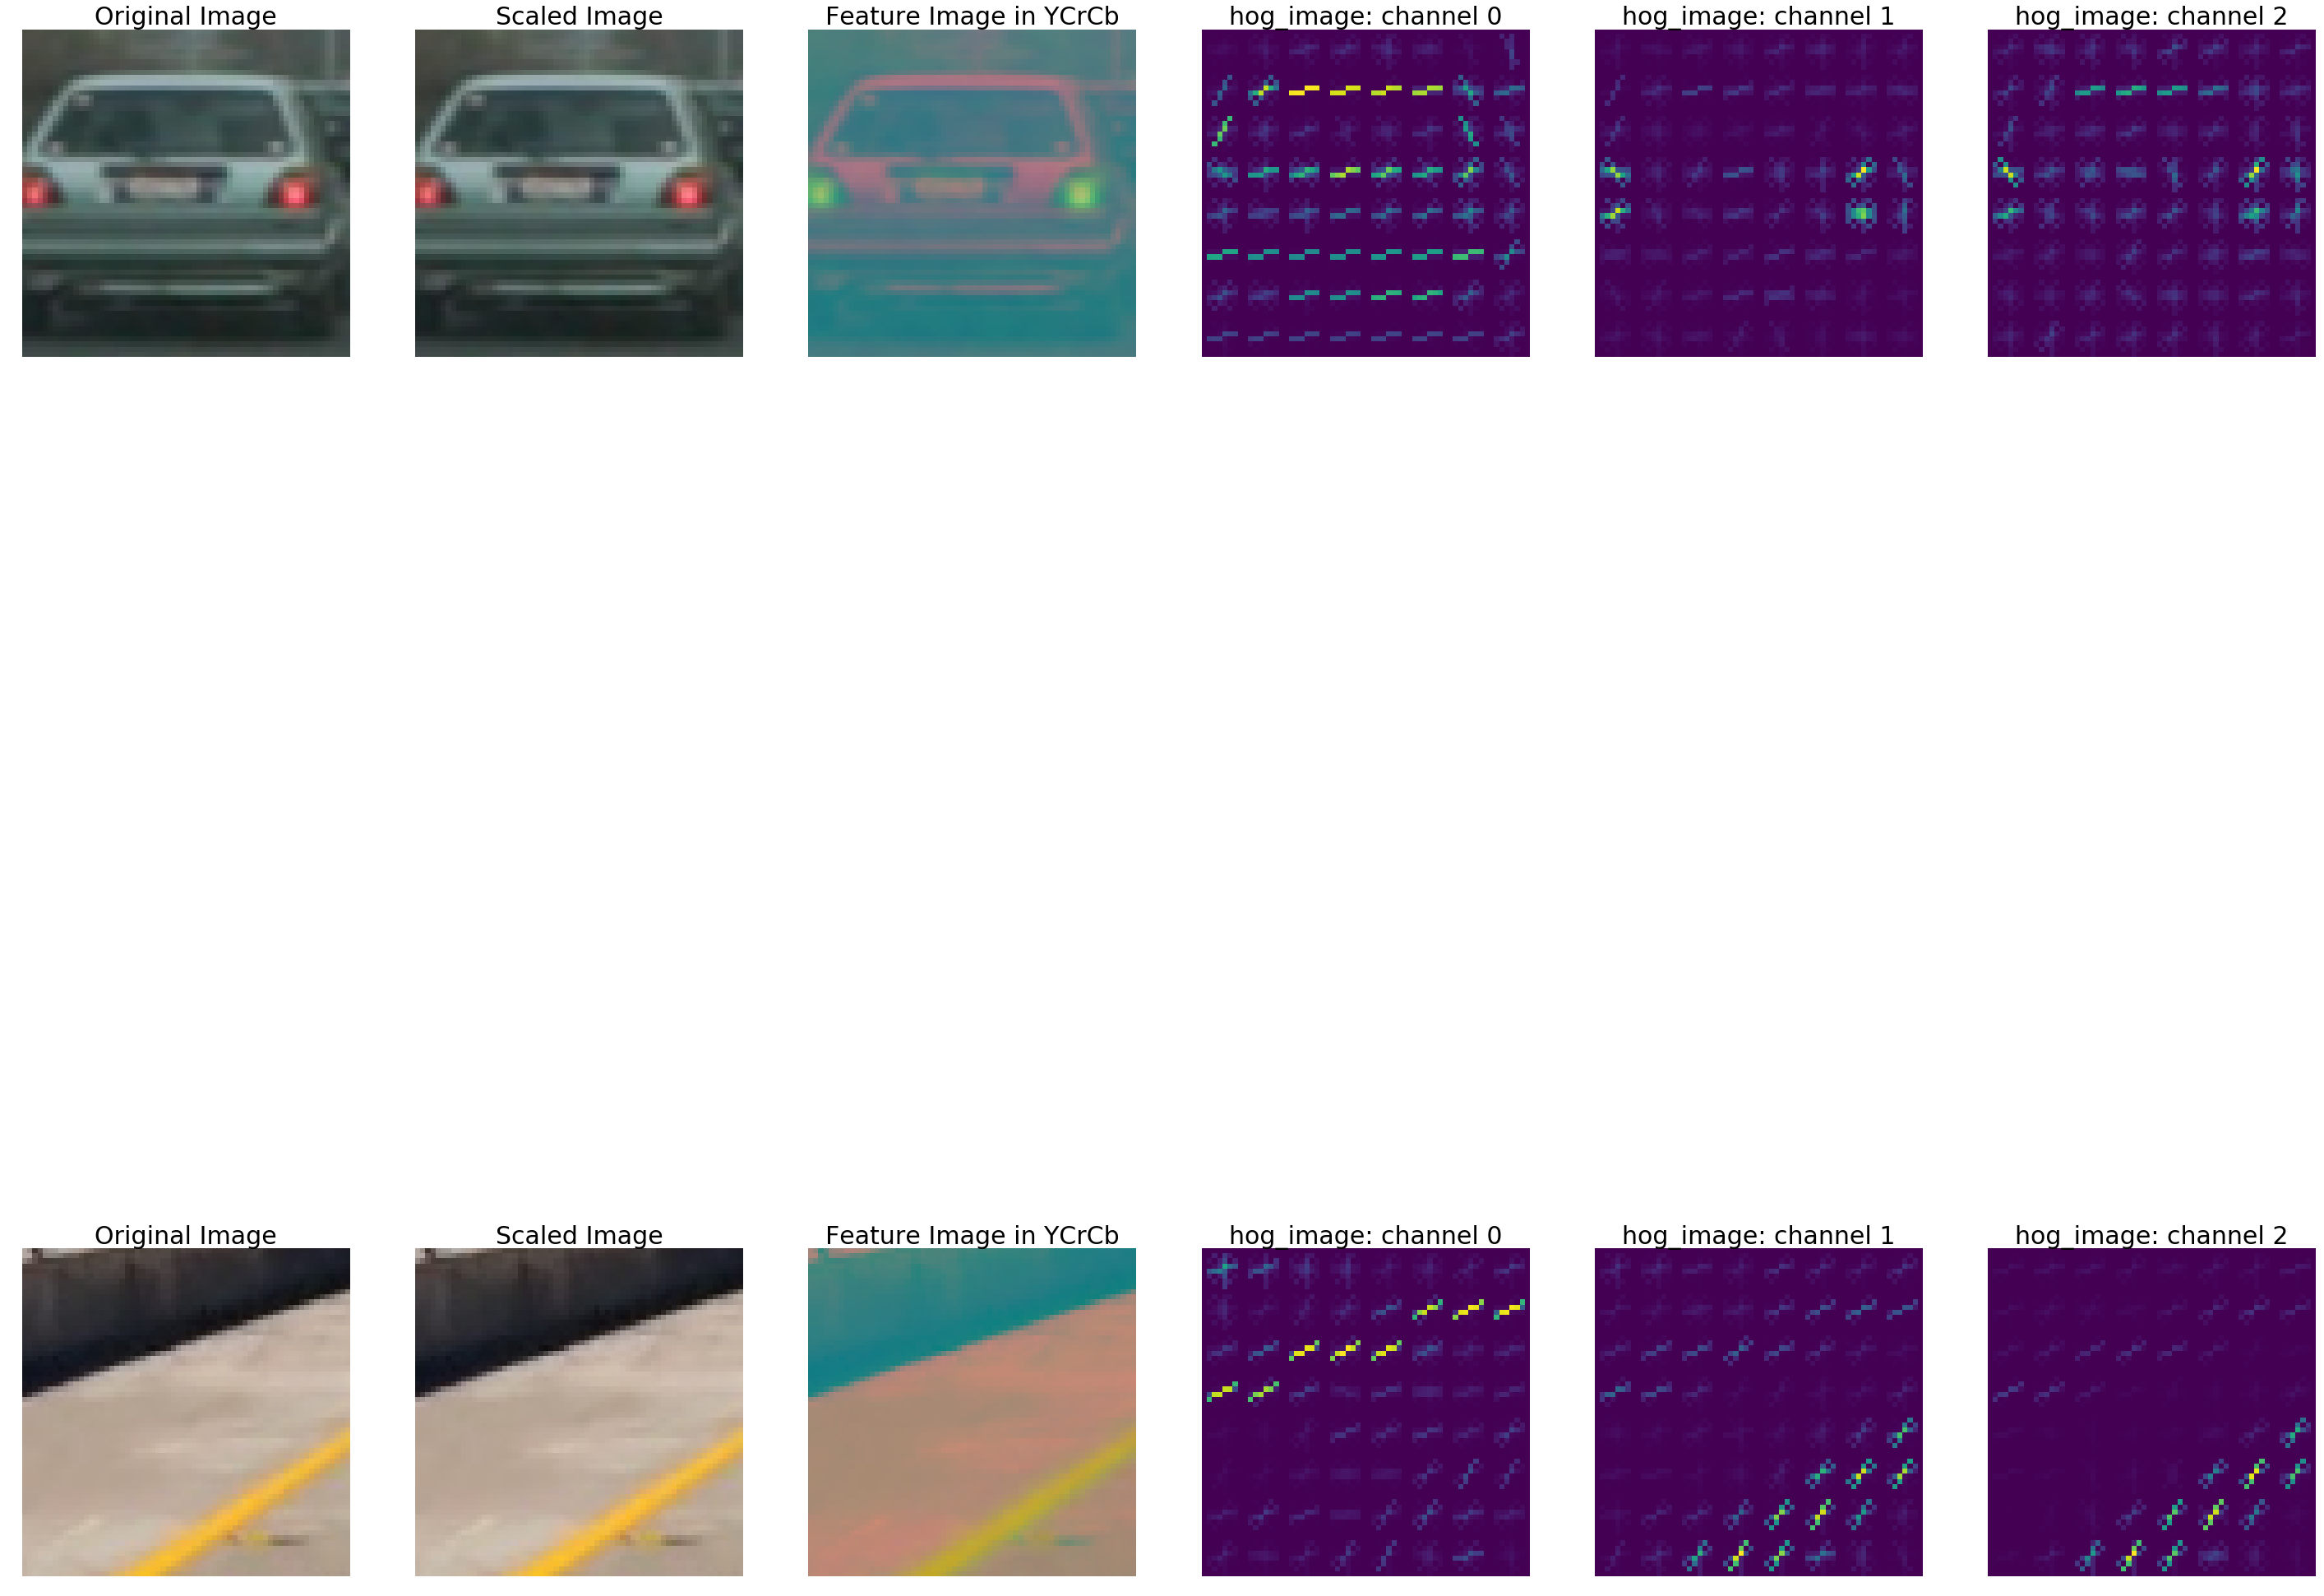

In [3]:

# generate intermediate test images for experimentation
carpath = "./output_images/example_car.png"
notcarpath = "./output_images/example_not_car.png"

test_images = [carpath, notcarpath]
# cspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
cspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orient=9 
pix_per_cell=8
cell_per_block=2

fig = plt.figure()
fig.set_size_inches(50,50)
total_image_count = len(test_images)
image_count = 1

for file in test_images:
    fname = os.path.split(file)[-1]
    image = mpimg.imread(file)
    max_val = np.max(image)
    print("max_val " + str(max_val))
#     scaled_img = (image/max_val)*255
    scaled_img = (image/max_val)
    
    for color_space in cspaces:
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(scaled_img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
#         feature_image = scaled_img.astype(np.float32)
#         max_val = np.max(feature_image)
#         print("max_val " + color_space + str(max_val))
        
#         scaled_img = (feature_image/max_val)*255
#         scaled_img = feature_image
        plot_img = False
        if color_space == 'YCrCb':
            plot_img = True
            
        
        if plot_img:
            ax = fig.add_subplot(total_image_count, 6, image_count)
            ax.imshow(image)
            ax.axis('off')
            ax.set_title('Original Image', fontsize=30)
            image_count += 1
            ax = fig.add_subplot(total_image_count, 6, image_count)
            ax.imshow(scaled_img)
            ax.axis('off')
            ax.set_title('Scaled Image', fontsize=30)
            image_count += 1
            ax = fig.add_subplot(total_image_count, 6, image_count)
            ax.imshow(feature_image)
            ax.axis('off')
            ax.set_title('Feature Image in YCrCb', fontsize=30)
            image_count += 1

        for hog_channel in range(scaled_img.shape[2]):
            hog_features, hog_image = F.get_hog_features(
                feature_image[:,:,hog_channel], orient, 
                pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            cv2.imwrite('./output_images/Hog_' + str(hog_channel) + "_" + fname, hog_image)
            if plot_img:
                ax = fig.add_subplot(total_image_count, 6, image_count)
                ax.imshow(hog_image)
                ax.axis('off')
                ax.set_title('hog_image: channel ' + str(hog_channel), fontsize=30)
                image_count += 1

plt.show()
    

In [19]:
def process_image(img, debug=False):
    global cars
    # scaled_img = img.astype(np.float32)/255
    max_val = np.max(img)
    print("max_val " + str(max_val))
    scaled_img = (img.astype(np.float32)/max_val)
    
    windows = p.getWindows(scaled_img)
    print("all:", len(windows))
    possible_cars = p.find_cars(scaled_img, windows, clf, X_scaler)
    print("possible_cars:", len(possible_cars))
    final_cars = p.harden_detections(img, possible_cars)
    if cars:
        cars_to_draw = cars.updateNewCars(final_cars)
        print("cars_to_draw: {}".format(cars_to_draw))
        final_img = p.draw_boxes(np.copy(img), cars_to_draw)
    else:
        final_img = p.draw_boxes(np.copy(img), final_cars)
    
    if debug:
        pre_filter_img = p.draw_boxes(img, possible_cars)
        return final_img, pre_filter_img
    else:
        return final_img


Testing image ./test_images/test1.jpg
max_val 255
all: 4119
positive_predictions: 70
positive_predictions_above_threshold: 29
possible_cars: 29
Labels: 2
Testing image ./test_images/test2.jpg
max_val 255
all: 4119
positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Testing image ./test_images/test3.jpg
max_val 255
all: 4119
positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Testing image ./test_images/test4.jpg
max_val 255
all: 4119
positive_predictions: 55
positive_predictions_above_threshold: 18
possible_cars: 18
Labels: 2
Testing image ./test_images/test5.jpg
max_val 255
all: 4119
positive_predictions: 53
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 2
Testing image ./test_images/test6.jpg
max_val 255
all: 4119
positive_predictions: 52
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 2


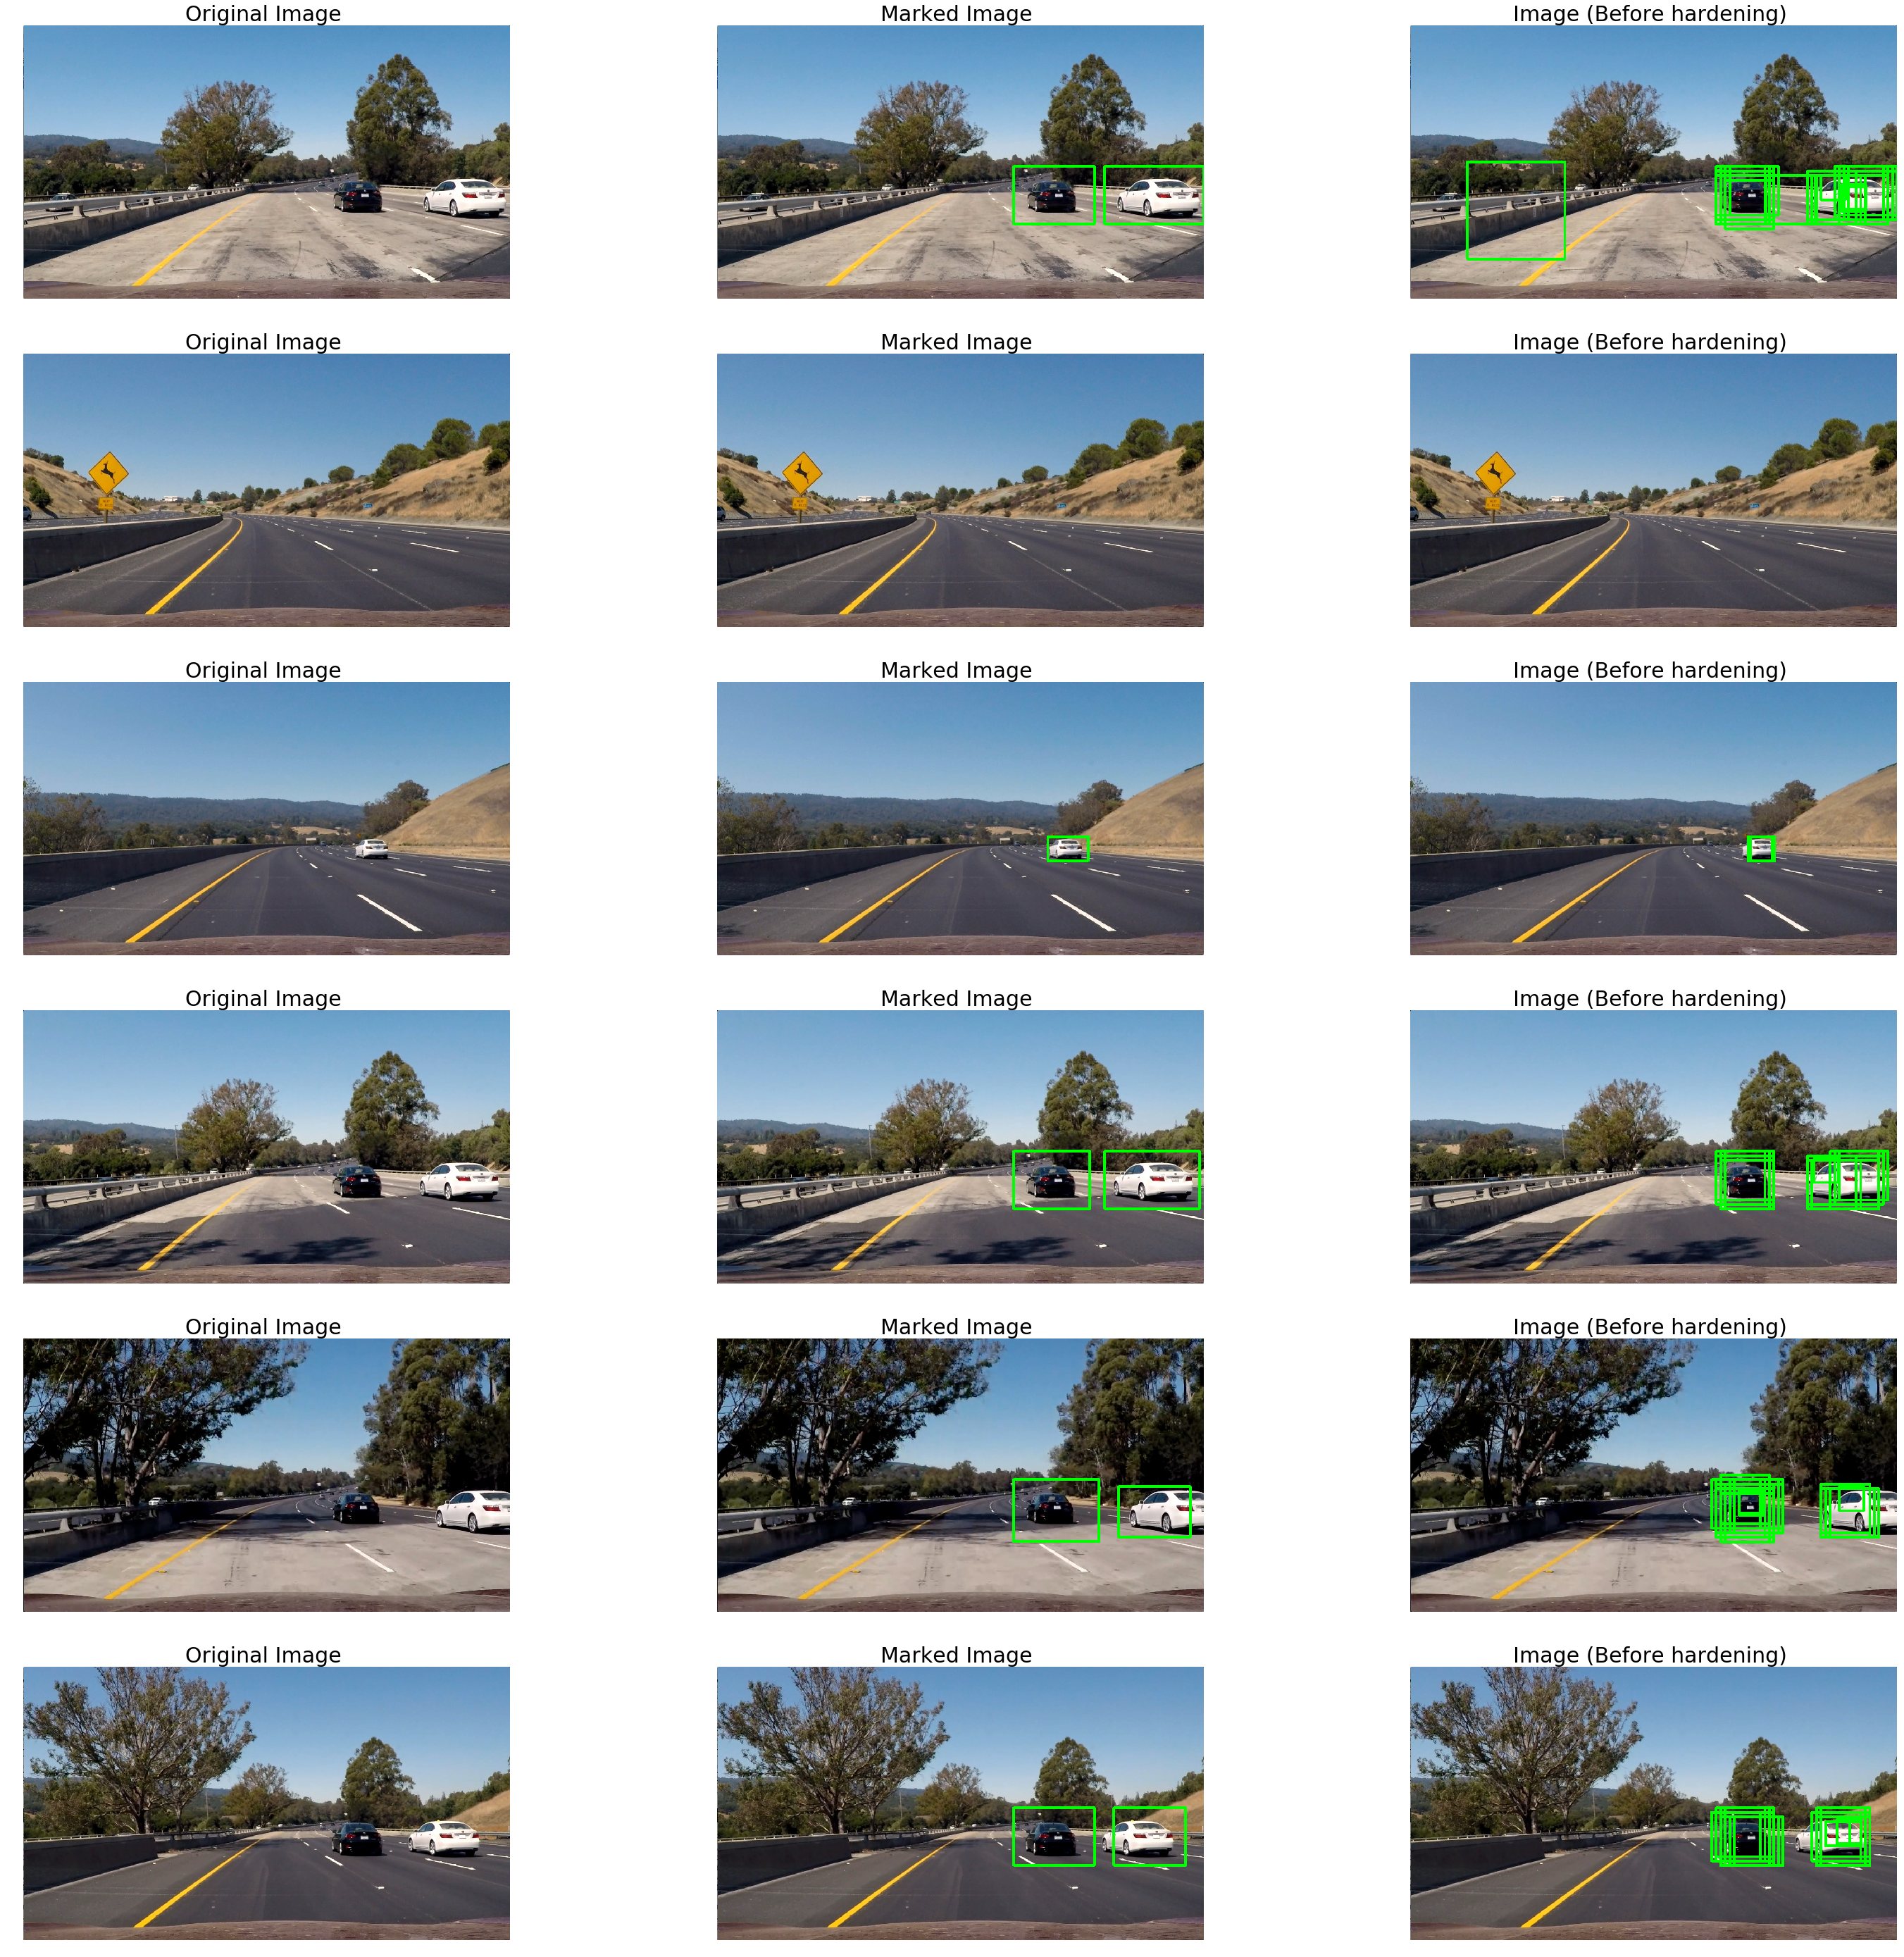

In [4]:
# Test images
cars = None
image_path = "./test_images/*.jpg"
images = glob.glob(image_path)

fig = plt.figure()
fig.set_size_inches(50,50)

total_image_count = len(images)
image_count = 1

for fname in images:
    print("Testing image {}".format(fname))

    img = mpimg.imread(fname)
    marked_img, pre_filter_img = process_image(img, debug=True)

    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Original Image ', fontsize=30)
    image_count += 1

    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(marked_img)
    ax.axis('off')
    ax.set_title('Marked Image ', fontsize=30)
    image_count += 1

    
    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(pre_filter_img)
    ax.axis('off')
    ax.set_title('Image (Before hardening) ', fontsize=30)
    image_count += 1
    
    cv2.imwrite('./output_images/Marked_' + os.path.split(fname)[-1], marked_img)
    cv2.imwrite('./output_images/pre_filter_img_' + os.path.split(fname)[-1], pre_filter_img)

plt.show()


In [36]:
# Test Video

cars = c.Cars()
# clip1 = VideoFileClip("./project_video.mp4")
# clip = clip1.subclip(38, 39)
clip = VideoFileClip("./project_video.mp4")
output_video = "./project_video_marked.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)

max_val 255
all: 4119
positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
[MoviePy] >>>> Building video ./project_video_marked.mp4
[MoviePy] Writing video ./project_video_marked.mp4







  0%|          | 0/1261 [00:00<?, ?it/s]

max_val 255
all: 4119







  0%|          | 1/1261 [00:12<4:24:10, 12.58s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  0%|          | 2/1261 [00:25<4:24:25, 12.60s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  0%|          | 3/1261 [00:38<4:30:07, 12.88s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  0%|          | 4/1261 [00:52<4:35:31, 13.15s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  0%|          | 5/1261 [01:05<4:37:00, 13.23s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  0%|          | 6/1261 [01:18<4:35:06, 13.15s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 7/1261 [01:32<4:35:36, 13.19s/it]

positive_predictions: 1
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 8/1261 [01:45<4:33:41, 13.11s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 9/1261 [01:58<4:33:26, 13.10s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 10/1261 [02:11<4:33:45, 13.13s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 11/1261 [02:25<4:39:54, 13.44s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 12/1261 [02:38<4:34:19, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 13/1261 [02:50<4:31:31, 13.05s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 14/1261 [03:04<4:33:51, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|          | 15/1261 [03:17<4:30:32, 13.03s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|▏         | 16/1261 [03:29<4:28:45, 12.95s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|▏         | 17/1261 [03:43<4:31:01, 13.07s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  1%|▏         | 18/1261 [03:56<4:29:17, 13.00s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 19/1261 [04:08<4:26:21, 12.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 20/1261 [04:21<4:24:02, 12.77s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 21/1261 [04:34<4:27:01, 12.92s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 22/1261 [04:47<4:30:02, 13.08s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 23/1261 [05:00<4:28:56, 13.03s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 24/1261 [05:14<4:32:33, 13.22s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 25/1261 [05:27<4:31:54, 13.20s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 26/1261 [05:41<4:33:21, 13.28s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 27/1261 [05:54<4:36:01, 13.42s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 28/1261 [06:07<4:32:11, 13.25s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 29/1261 [06:21<4:33:36, 13.33s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 30/1261 [06:33<4:30:07, 13.17s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  2%|▏         | 31/1261 [06:48<4:35:56, 13.46s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 32/1261 [07:01<4:32:33, 13.31s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 33/1261 [07:14<4:32:12, 13.30s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 34/1261 [07:27<4:32:09, 13.31s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 35/1261 [07:40<4:31:39, 13.29s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 36/1261 [07:54<4:33:06, 13.38s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 37/1261 [08:08<4:35:55, 13.53s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 38/1261 [08:22<4:38:13, 13.65s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 39/1261 [08:35<4:38:03, 13.65s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 40/1261 [08:49<4:36:16, 13.58s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 41/1261 [09:02<4:33:34, 13.45s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 42/1261 [09:15<4:32:10, 13.40s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 43/1261 [09:29<4:31:57, 13.40s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  3%|▎         | 44/1261 [09:42<4:31:56, 13.41s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▎         | 45/1261 [09:56<4:33:04, 13.47s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▎         | 46/1261 [10:09<4:30:31, 13.36s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▎         | 47/1261 [10:22<4:31:47, 13.43s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 48/1261 [10:36<4:33:38, 13.54s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 49/1261 [10:50<4:37:39, 13.75s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 50/1261 [11:04<4:39:13, 13.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 51/1261 [11:18<4:38:52, 13.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119
















  4%|▍         | 52/1261 [11:32<4:40:47, 13.94s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 53/1261 [11:46<4:39:25, 13.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 54/1261 [12:00<4:36:48, 13.76s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 55/1261 [12:14<4:37:29, 13.81s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  4%|▍         | 56/1261 [12:27<4:36:45, 13.78s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 57/1261 [12:41<4:36:25, 13.78s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 58/1261 [12:55<4:34:23, 13.69s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 59/1261 [13:08<4:32:37, 13.61s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 60/1261 [13:21<4:31:36, 13.57s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 61/1261 [13:35<4:29:53, 13.49s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 62/1261 [13:48<4:30:00, 13.51s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▍         | 63/1261 [14:02<4:28:51, 13.47s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▌         | 64/1261 [14:15<4:28:27, 13.46s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▌         | 65/1261 [14:29<4:30:37, 13.58s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▌         | 66/1261 [14:43<4:32:59, 13.71s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▌         | 67/1261 [14:57<4:33:59, 13.77s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▌         | 68/1261 [15:11<4:34:58, 13.83s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  5%|▌         | 69/1261 [15:24<4:29:00, 13.54s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 70/1261 [15:36<4:23:52, 13.29s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 71/1261 [15:50<4:26:33, 13.44s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 72/1261 [16:04<4:25:28, 13.40s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 73/1261 [16:17<4:23:15, 13.30s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 74/1261 [16:29<4:20:19, 13.16s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 75/1261 [16:42<4:17:47, 13.04s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 76/1261 [16:55<4:15:58, 12.96s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 77/1261 [17:08<4:14:28, 12.90s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▌         | 78/1261 [17:21<4:13:45, 12.87s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▋         | 79/1261 [17:33<4:13:24, 12.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▋         | 80/1261 [17:46<4:12:43, 12.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  6%|▋         | 81/1261 [17:59<4:11:25, 12.78s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 82/1261 [18:12<4:11:00, 12.77s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 83/1261 [18:24<4:10:55, 12.78s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 84/1261 [18:37<4:09:46, 12.73s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 85/1261 [18:50<4:09:33, 12.73s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 86/1261 [19:02<4:09:05, 12.72s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 87/1261 [19:15<4:08:54, 12.72s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 88/1261 [19:28<4:08:17, 12.70s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 89/1261 [19:40<4:07:58, 12.69s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 90/1261 [19:53<4:07:47, 12.70s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 91/1261 [20:06<4:06:48, 12.66s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 92/1261 [20:18<4:06:32, 12.65s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 93/1261 [20:31<4:06:03, 12.64s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  7%|▋         | 94/1261 [20:44<4:06:11, 12.66s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 95/1261 [20:56<4:06:13, 12.67s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 96/1261 [21:10<4:09:43, 12.86s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 97/1261 [21:23<4:14:49, 13.14s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 98/1261 [21:37<4:16:01, 13.21s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 99/1261 [21:50<4:18:00, 13.32s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 100/1261 [22:04<4:17:51, 13.33s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 101/1261 [22:16<4:13:53, 13.13s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 102/1261 [22:29<4:11:28, 13.02s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 103/1261 [22:42<4:08:51, 12.89s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 104/1261 [22:55<4:07:52, 12.85s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 105/1261 [23:07<4:06:55, 12.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 106/1261 [23:20<4:08:53, 12.93s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  8%|▊         | 107/1261 [23:34<4:11:22, 13.07s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▊         | 108/1261 [23:47<4:10:51, 13.05s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▊         | 109/1261 [24:00<4:13:35, 13.21s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▊         | 110/1261 [24:14<4:14:48, 13.28s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 111/1261 [24:28<4:16:26, 13.38s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 112/1261 [24:41<4:16:57, 13.42s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 113/1261 [24:54<4:15:40, 13.36s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 114/1261 [25:08<4:18:20, 13.51s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 115/1261 [25:21<4:15:38, 13.38s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 116/1261 [25:35<4:15:01, 13.36s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 117/1261 [25:48<4:14:30, 13.35s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 118/1261 [26:01<4:11:31, 13.20s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







  9%|▉         | 119/1261 [26:13<4:08:22, 13.05s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 120/1261 [26:27<4:09:31, 13.12s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 121/1261 [26:40<4:08:17, 13.07s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 122/1261 [26:53<4:10:07, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 123/1261 [27:06<4:10:03, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 124/1261 [27:19<4:09:50, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 125/1261 [27:33<4:08:56, 13.15s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|▉         | 126/1261 [27:46<4:08:45, 13.15s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|█         | 127/1261 [27:59<4:09:01, 13.18s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|█         | 128/1261 [28:12<4:08:27, 13.16s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|█         | 129/1261 [28:25<4:07:38, 13.13s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|█         | 130/1261 [28:38<4:08:10, 13.17s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|█         | 131/1261 [28:52<4:08:13, 13.18s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 10%|█         | 132/1261 [29:05<4:08:30, 13.21s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█         | 133/1261 [29:18<4:08:31, 13.22s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█         | 134/1261 [29:31<4:07:57, 13.20s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█         | 135/1261 [29:44<4:07:51, 13.21s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█         | 136/1261 [29:58<4:07:32, 13.20s/it]

positive_predictions: 3
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((47, 402), (154, 465))]
max_val 255
all: 4119







 11%|█         | 137/1261 [30:11<4:06:47, 13.17s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((47, 402), (154, 465))]
max_val 255
all: 4119







 11%|█         | 138/1261 [30:24<4:06:53, 13.19s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((47, 402), (154, 465))]
max_val 255
all: 4119







 11%|█         | 139/1261 [30:37<4:06:59, 13.21s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█         | 140/1261 [30:51<4:07:54, 13.27s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█         | 141/1261 [31:04<4:08:12, 13.30s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█▏        | 142/1261 [31:17<4:08:06, 13.30s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█▏        | 143/1261 [31:31<4:07:33, 13.29s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█▏        | 144/1261 [31:44<4:06:44, 13.25s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 11%|█▏        | 145/1261 [31:57<4:06:15, 13.24s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 146/1261 [32:10<4:04:59, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 147/1261 [32:23<4:04:18, 13.16s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 148/1261 [32:36<4:04:19, 13.17s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 149/1261 [32:49<4:04:05, 13.17s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 150/1261 [33:03<4:03:35, 13.16s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 151/1261 [33:16<4:02:46, 13.12s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 152/1261 [33:29<4:02:22, 13.11s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 153/1261 [33:42<4:02:07, 13.11s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 154/1261 [33:55<4:02:03, 13.12s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 155/1261 [34:08<4:01:53, 13.12s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 156/1261 [34:21<4:01:55, 13.14s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 12%|█▏        | 157/1261 [34:34<4:01:24, 13.12s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 13%|█▎        | 158/1261 [34:48<4:01:31, 13.14s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 13%|█▎        | 159/1261 [35:01<4:01:24, 13.14s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 13%|█▎        | 160/1261 [35:14<4:01:33, 13.16s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 13%|█▎        | 161/1261 [35:27<4:00:46, 13.13s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 13%|█▎        | 162/1261 [35:40<4:01:22, 13.18s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((1187, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 163/1261 [35:54<4:02:09, 13.23s/it]

positive_predictions: 10
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1181, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 164/1261 [36:07<4:01:28, 13.21s/it]

positive_predictions: 14
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1175, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 165/1261 [36:20<4:00:40, 13.18s/it]

positive_predictions: 16
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1115, 390), (1279, 535)), ((1175, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 166/1261 [36:33<4:00:33, 13.18s/it]

positive_predictions: 15
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1103, 390), (1279, 535)), ((1175, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 167/1261 [36:46<4:00:09, 13.17s/it]

positive_predictions: 19
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1115, 390), (1279, 523)), ((1175, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 168/1261 [37:00<4:00:36, 13.21s/it]

positive_predictions: 21
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1103, 390), (1279, 535)), ((1175, 390), (1279, 453))]
max_val 255
all: 4119







 13%|█▎        | 169/1261 [37:13<4:00:00, 13.19s/it]

positive_predictions: 19
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((1103, 384), (1279, 523))]
max_val 255
all: 4119







 13%|█▎        | 170/1261 [37:26<3:59:06, 13.15s/it]

positive_predictions: 17
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1103, 384), (1279, 523))]
max_val 255
all: 4119







 14%|█▎        | 171/1261 [37:38<3:56:45, 13.03s/it]

positive_predictions: 15
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1103, 384), (1279, 523))]
max_val 255
all: 4119







 14%|█▎        | 172/1261 [37:51<3:54:11, 12.90s/it]

positive_predictions: 17
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 384), (1279, 523))]
max_val 255
all: 4119







 14%|█▎        | 173/1261 [38:04<3:52:49, 12.84s/it]

positive_predictions: 15
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 396), (1279, 523))]
max_val 255
all: 4119







 14%|█▍        | 174/1261 [38:16<3:52:04, 12.81s/it]

positive_predictions: 17
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 396), (1279, 523))]
max_val 255
all: 4119







 14%|█▍        | 175/1261 [38:29<3:51:34, 12.79s/it]

positive_predictions: 15
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 390), (1279, 523))]
max_val 255
all: 4119







 14%|█▍        | 176/1261 [38:42<3:52:12, 12.84s/it]

positive_predictions: 15
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 396), (1279, 535))]
max_val 255
all: 4119







 14%|█▍        | 177/1261 [38:55<3:52:21, 12.86s/it]

positive_predictions: 17
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 390), (1279, 523))]
max_val 255
all: 4119







 14%|█▍        | 178/1261 [39:08<3:52:00, 12.85s/it]

positive_predictions: 15
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 390), (1268, 523))]
max_val 255
all: 4119







 14%|█▍        | 179/1261 [39:21<3:51:16, 12.82s/it]

positive_predictions: 15
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 390), (1268, 523))]
max_val 255
all: 4119







 14%|█▍        | 180/1261 [39:33<3:49:55, 12.76s/it]

positive_predictions: 15
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 384), (1268, 523))]
max_val 255
all: 4119







 14%|█▍        | 181/1261 [39:46<3:49:03, 12.73s/it]

positive_predictions: 12
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 384), (1268, 523))]
max_val 255
all: 4119







 14%|█▍        | 182/1261 [39:59<3:47:53, 12.67s/it]

positive_predictions: 14
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 390), (1256, 523))]
max_val 255
all: 4119







 15%|█▍        | 183/1261 [40:11<3:47:06, 12.64s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 390), (1246, 523))]
max_val 255
all: 4119








 15%|█▍        | 184/1261 [40:24<3:46:04, 12.59s/it]

positive_predictions: 14
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 384), (1256, 523))]
max_val 255
all: 4119







 15%|█▍        | 185/1261 [40:36<3:45:33, 12.58s/it]

positive_predictions: 18
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 390), (1256, 523))]
max_val 255
all: 4119







 15%|█▍        | 186/1261 [40:49<3:45:27, 12.58s/it]

positive_predictions: 13
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1256, 535))]
max_val 255
all: 4119







 15%|█▍        | 187/1261 [41:01<3:46:07, 12.63s/it]

positive_predictions: 15
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1256, 535))]
max_val 255
all: 4119







 15%|█▍        | 188/1261 [41:14<3:46:30, 12.67s/it]

positive_predictions: 17
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 396), (1256, 535))]
max_val 255
all: 4119







 15%|█▍        | 189/1261 [41:27<3:46:18, 12.67s/it]

positive_predictions: 16
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1256, 535))]
max_val 255
all: 4119







 15%|█▌        | 190/1261 [41:40<3:46:12, 12.67s/it]

positive_predictions: 15
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1244, 523))]
max_val 255
all: 4119







 15%|█▌        | 191/1261 [41:52<3:45:56, 12.67s/it]

positive_predictions: 17
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1244, 523))]
max_val 255
all: 4119







 15%|█▌        | 192/1261 [42:05<3:46:09, 12.69s/it]

positive_predictions: 17
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1244, 523))]
max_val 255
all: 4119







 15%|█▌        | 193/1261 [42:18<3:46:41, 12.74s/it]

positive_predictions: 19
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1067, 390), (1244, 523))]
max_val 255
all: 4119







 15%|█▌        | 194/1261 [42:31<3:46:59, 12.76s/it]

positive_predictions: 19
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 390), (1244, 535))]
max_val 255
all: 4119







 15%|█▌        | 195/1261 [42:44<3:47:23, 12.80s/it]

positive_predictions: 19
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 390), (1244, 535))]
max_val 255
all: 4119







 16%|█▌        | 196/1261 [42:56<3:46:38, 12.77s/it]

positive_predictions: 17
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 390), (1232, 523))]
max_val 255
all: 4119







 16%|█▌        | 197/1261 [43:09<3:46:37, 12.78s/it]

positive_predictions: 19
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 384), (1232, 523))]
max_val 255
all: 4119







 16%|█▌        | 198/1261 [43:22<3:46:27, 12.78s/it]

positive_predictions: 19
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1103, 384), (1222, 453)), ((1055, 384), (1232, 523))]
max_val 255
all: 4119







 16%|█▌        | 199/1261 [43:35<3:46:23, 12.79s/it]

positive_predictions: 20
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 384), (1232, 511)), ((1055, 384), (1232, 523))]
max_val 255
all: 4119







 16%|█▌        | 200/1261 [43:47<3:46:15, 12.79s/it]

positive_predictions: 13
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1097, 384), (1216, 459)), ((1055, 384), (1232, 523))]
max_val 255
all: 4119







 16%|█▌        | 201/1261 [44:00<3:45:50, 12.78s/it]

positive_predictions: 15
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 384), (1232, 523)), ((1097, 384), (1216, 459))]
max_val 255
all: 4119







 16%|█▌        | 202/1261 [44:13<3:44:30, 12.72s/it]

positive_predictions: 18
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 384), (1232, 523)), ((1097, 384), (1216, 459))]
max_val 255
all: 4119







 16%|█▌        | 203/1261 [44:25<3:43:52, 12.70s/it]

positive_predictions: 18
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 384), (1232, 523)), ((1097, 384), (1216, 459))]
max_val 255
all: 4119







 16%|█▌        | 204/1261 [44:38<3:44:20, 12.73s/it]

positive_predictions: 20
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 384), (1232, 523)), ((1097, 384), (1216, 459))]
max_val 255
all: 4119







 16%|█▋        | 205/1261 [44:51<3:45:38, 12.82s/it]

positive_predictions: 20
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((1055, 390), (1232, 523))]
max_val 255
all: 4119







 16%|█▋        | 206/1261 [45:04<3:46:15, 12.87s/it]

positive_predictions: 20
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 390), (1220, 523))]
max_val 255
all: 4119







 16%|█▋        | 207/1261 [45:17<3:46:18, 12.88s/it]

positive_predictions: 17
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 390), (1220, 523))]
max_val 255
all: 4119







 16%|█▋        | 208/1261 [45:30<3:46:38, 12.91s/it]

positive_predictions: 17
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 390), (1232, 523))]
max_val 255
all: 4119







 17%|█▋        | 209/1261 [45:43<3:46:07, 12.90s/it]

positive_predictions: 20
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 210/1261 [45:56<3:44:44, 12.83s/it]

positive_predictions: 18
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 211/1261 [46:08<3:42:40, 12.72s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1091, 390), (1204, 453)), ((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 212/1261 [46:21<3:45:31, 12.90s/it]

positive_predictions: 12
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1091, 396), (1204, 453)), ((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 213/1261 [46:35<3:46:32, 12.97s/it]

positive_predictions: 15
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 384), (1220, 523)), ((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 214/1261 [46:47<3:45:15, 12.91s/it]

positive_predictions: 16
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 384), (1220, 523)), ((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 215/1261 [47:00<3:44:45, 12.89s/it]

positive_predictions: 17
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 396), (1220, 523)), ((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 216/1261 [47:13<3:43:32, 12.83s/it]

positive_predictions: 17
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 390), (1220, 523)), ((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 217/1261 [47:25<3:42:02, 12.76s/it]

positive_predictions: 16
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 218/1261 [47:38<3:41:15, 12.73s/it]

positive_predictions: 14
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 219/1261 [47:51<3:40:18, 12.69s/it]

positive_predictions: 14
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 390), (1220, 523))]
max_val 255
all: 4119







 17%|█▋        | 220/1261 [48:03<3:39:43, 12.66s/it]

positive_predictions: 15
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 396), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 221/1261 [48:16<3:40:02, 12.69s/it]

positive_predictions: 18
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 396), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 222/1261 [48:29<3:40:15, 12.72s/it]

positive_predictions: 17
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 223/1261 [48:42<3:39:55, 12.71s/it]

positive_predictions: 18
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 224/1261 [48:54<3:40:15, 12.74s/it]

positive_predictions: 16
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 225/1261 [49:07<3:41:14, 12.81s/it]

positive_predictions: 23
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 226/1261 [49:20<3:41:16, 12.83s/it]

positive_predictions: 14
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 227/1261 [49:33<3:41:21, 12.84s/it]

positive_predictions: 21
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 228/1261 [49:46<3:41:23, 12.86s/it]

positive_predictions: 19
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 229/1261 [49:59<3:40:50, 12.84s/it]

positive_predictions: 16
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 230/1261 [50:12<3:40:04, 12.81s/it]

positive_predictions: 16
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1220, 523))]
max_val 255
all: 4119







 18%|█▊        | 231/1261 [50:24<3:38:20, 12.72s/it]

positive_predictions: 28
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 232/1261 [50:37<3:38:29, 12.74s/it]

positive_predictions: 23
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1208, 523))]
max_val 255
all: 4119







 18%|█▊        | 233/1261 [50:50<3:38:45, 12.77s/it]

positive_predictions: 21
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 396), (1196, 523))]
max_val 255
all: 4119







 19%|█▊        | 234/1261 [51:02<3:38:22, 12.76s/it]

positive_predictions: 19
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1196, 523))]
max_val 255
all: 4119







 19%|█▊        | 235/1261 [51:15<3:39:09, 12.82s/it]

positive_predictions: 18
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 390), (1196, 523))]
max_val 255
all: 4119







 19%|█▊        | 236/1261 [51:28<3:39:20, 12.84s/it]

positive_predictions: 18
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 396), (1196, 523))]
max_val 255
all: 4119







 19%|█▉        | 237/1261 [51:41<3:38:50, 12.82s/it]

positive_predictions: 14
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 390), (1196, 523))]
max_val 255
all: 4119







 19%|█▉        | 238/1261 [51:54<3:37:59, 12.78s/it]

positive_predictions: 15
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 390), (1196, 523))]
max_val 255
all: 4119







 19%|█▉        | 239/1261 [52:06<3:37:42, 12.78s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 390), (1184, 523))]
max_val 255
all: 4119







 19%|█▉        | 240/1261 [52:19<3:37:28, 12.78s/it]

positive_predictions: 16
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 396), (1184, 523))]
max_val 255
all: 4119







 19%|█▉        | 241/1261 [52:32<3:37:13, 12.78s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 396), (1168, 453)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 19%|█▉        | 242/1261 [52:45<3:37:31, 12.81s/it]

positive_predictions: 13
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1019, 396), (1184, 523)), ((1055, 396), (1168, 453))]
max_val 255
all: 4119







 19%|█▉        | 243/1261 [52:58<3:37:23, 12.81s/it]

positive_predictions: 16
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1019, 396), (1184, 523)), ((1055, 396), (1168, 453))]
max_val 255
all: 4119







 19%|█▉        | 244/1261 [53:11<3:37:05, 12.81s/it]

positive_predictions: 12
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1049, 390), (1168, 453)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 19%|█▉        | 245/1261 [53:23<3:36:18, 12.77s/it]

positive_predictions: 16
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1019, 396), (1184, 523)), ((1049, 390), (1168, 453))]
max_val 255
all: 4119







 20%|█▉        | 246/1261 [53:36<3:35:30, 12.74s/it]

positive_predictions: 19
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1049, 396), (1162, 453)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 20%|█▉        | 247/1261 [53:49<3:35:24, 12.75s/it]

positive_predictions: 20
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 396), (1162, 465)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 20%|█▉        | 248/1261 [54:01<3:34:59, 12.73s/it]

positive_predictions: 19
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 390), (1184, 523)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 20%|█▉        | 249/1261 [54:14<3:34:26, 12.71s/it]

positive_predictions: 22
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 390), (1196, 523)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 20%|█▉        | 250/1261 [54:27<3:33:19, 12.66s/it]

positive_predictions: 25
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 390), (1184, 523)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 20%|█▉        | 251/1261 [54:39<3:33:21, 12.67s/it]

positive_predictions: 14
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 390), (1184, 523)), ((1019, 396), (1184, 523))]
max_val 255
all: 4119







 20%|█▉        | 252/1261 [54:52<3:34:05, 12.73s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((1007, 396), (1184, 523))]
max_val 255
all: 4119







 20%|██        | 253/1261 [55:05<3:34:10, 12.75s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 396), (1184, 523))]
max_val 255
all: 4119







 20%|██        | 254/1261 [55:18<3:34:43, 12.79s/it]

positive_predictions: 18
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 390), (1184, 523))]
max_val 255
all: 4119







 20%|██        | 255/1261 [55:31<3:34:24, 12.79s/it]

positive_predictions: 25
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 396), (1184, 523))]
max_val 255
all: 4119







 20%|██        | 256/1261 [55:43<3:33:52, 12.77s/it]

positive_predictions: 20
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 396), (1184, 523))]
max_val 255
all: 4119







 20%|██        | 257/1261 [55:56<3:33:11, 12.74s/it]

positive_predictions: 27
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 390), (1196, 523))]
max_val 255
all: 4119







 20%|██        | 258/1261 [56:09<3:33:21, 12.76s/it]

positive_predictions: 24
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1196, 523))]
max_val 255
all: 4119







 21%|██        | 259/1261 [56:22<3:33:51, 12.81s/it]

positive_predictions: 22
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1196, 523))]
max_val 255
all: 4119







 21%|██        | 260/1261 [56:35<3:34:12, 12.84s/it]

positive_predictions: 17
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1196, 523))]
max_val 255
all: 4119







 21%|██        | 261/1261 [56:47<3:33:48, 12.83s/it]

positive_predictions: 25
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 390), (1184, 523))]
max_val 255
all: 4119







 21%|██        | 262/1261 [57:00<3:32:47, 12.78s/it]

positive_predictions: 26
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 390), (1184, 523))]
max_val 255
all: 4119







 21%|██        | 263/1261 [57:13<3:31:56, 12.74s/it]

positive_predictions: 32
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 390), (1172, 511))]
max_val 255
all: 4119







 21%|██        | 264/1261 [57:25<3:30:58, 12.70s/it]

positive_predictions: 28
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 390), (1184, 523))]
max_val 255
all: 4119







 21%|██        | 265/1261 [57:38<3:30:41, 12.69s/it]

positive_predictions: 26
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 390), (1184, 523))]
max_val 255
all: 4119







 21%|██        | 266/1261 [57:51<3:31:09, 12.73s/it]

positive_predictions: 33
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1268, 523)), ((995, 390), (1184, 523))]
max_val 255
all: 4119







 21%|██        | 267/1261 [58:04<3:30:51, 12.73s/it]

positive_predictions: 28
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1172, 511)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 21%|██▏       | 268/1261 [58:16<3:31:05, 12.76s/it]

positive_predictions: 32
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1268, 523)), ((995, 384), (1172, 511))]
max_val 255
all: 4119







 21%|██▏       | 269/1261 [58:29<3:29:53, 12.70s/it]

positive_predictions: 26
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1013, 384), (1172, 511)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 21%|██▏       | 270/1261 [58:42<3:29:50, 12.70s/it]

positive_predictions: 24
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1172, 511)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 21%|██▏       | 271/1261 [58:55<3:30:19, 12.75s/it]

positive_predictions: 25
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 384), (1279, 523)), ((995, 384), (1172, 511))]
max_val 255
all: 4119







 22%|██▏       | 272/1261 [59:07<3:30:51, 12.79s/it]

positive_predictions: 24
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 384), (1279, 523)), ((995, 384), (1172, 511))]
max_val 255
all: 4119







 22%|██▏       | 273/1261 [59:20<3:31:16, 12.83s/it]

positive_predictions: 15
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 396), (1184, 523)), ((1007, 384), (1279, 523))]
max_val 255
all: 4119







 22%|██▏       | 274/1261 [59:33<3:30:35, 12.80s/it]

positive_predictions: 24
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1007, 384), (1279, 523)), ((1007, 396), (1184, 523))]
max_val 255
all: 4119







 22%|██▏       | 275/1261 [59:46<3:30:21, 12.80s/it]

positive_predictions: 27
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 390), (1279, 523)), ((1007, 396), (1184, 523))]
max_val 255
all: 4119







 22%|██▏       | 276/1261 [59:59<3:29:40, 12.77s/it]

positive_predictions: 27
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1279, 523)), ((1007, 396), (1184, 523))]
max_val 255
all: 4119







 22%|██▏       | 277/1261 [1:00:11<3:28:23, 12.71s/it]

positive_predictions: 24
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1268, 523)), ((1007, 396), (1184, 523))]
max_val 255
all: 4119







 22%|██▏       | 278/1261 [1:00:24<3:28:17, 12.71s/it]

positive_predictions: 23
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 372), (1279, 523)), ((1007, 396), (1184, 523))]
max_val 255
all: 4119







 22%|██▏       | 279/1261 [1:00:37<3:28:33, 12.74s/it]

positive_predictions: 27
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1268, 523)), ((1007, 396), (1184, 523))]
max_val 255
all: 4119







 22%|██▏       | 280/1261 [1:00:50<3:28:50, 12.77s/it]

positive_predictions: 21
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Add new car
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((1079, 384), (1268, 523)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 22%|██▏       | 281/1261 [1:01:02<3:29:11, 12.81s/it]

positive_predictions: 16
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1091, 396), (1268, 523)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 22%|██▏       | 282/1261 [1:01:15<3:28:38, 12.79s/it]

positive_predictions: 14
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1019, 396), (1160, 511)), ((1091, 396), (1268, 523)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 22%|██▏       | 283/1261 [1:01:28<3:28:01, 12.76s/it]

positive_predictions: 20
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((995, 396), (1172, 523)), ((1091, 396), (1268, 523)), ((995, 384), (1268, 523))]
max_val 255
all: 4119







 23%|██▎       | 284/1261 [1:01:41<3:27:29, 12.74s/it]

positive_predictions: 21
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((995, 396), (1268, 523)), ((995, 396), (1172, 523)), ((1091, 396), (1268, 523))]
max_val 255
all: 4119







 23%|██▎       | 285/1261 [1:01:53<3:26:54, 12.72s/it]

positive_predictions: 23
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((1001, 384), (1256, 523)), ((995, 396), (1172, 523))]
max_val 255
all: 4119







 23%|██▎       | 286/1261 [1:02:06<3:26:21, 12.70s/it]

positive_predictions: 23
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((983, 384), (1256, 523)), ((995, 396), (1172, 523))]
max_val 255
all: 4119







 23%|██▎       | 287/1261 [1:02:18<3:25:52, 12.68s/it]

positive_predictions: 20
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1256, 523))]
max_val 255
all: 4119







 23%|██▎       | 288/1261 [1:02:31<3:26:25, 12.73s/it]

positive_predictions: 19
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1160, 523)), ((995, 384), (1256, 523))]
max_val 255
all: 4119







 23%|██▎       | 289/1261 [1:02:44<3:26:11, 12.73s/it]

positive_predictions: 19
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1172, 523)), ((995, 384), (1256, 523))]
max_val 255
all: 4119







 23%|██▎       | 290/1261 [1:02:57<3:26:52, 12.78s/it]

positive_predictions: 27
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1172, 523)), ((995, 384), (1256, 523))]
max_val 255
all: 4119







 23%|██▎       | 291/1261 [1:03:10<3:27:19, 12.82s/it]

positive_predictions: 18
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1244, 523)), ((995, 396), (1172, 523))]
max_val 255
all: 4119







 23%|██▎       | 292/1261 [1:03:23<3:27:24, 12.84s/it]

positive_predictions: 15
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1067, 396), (1244, 523)), ((995, 396), (1244, 523)), ((995, 396), (1172, 523))]
max_val 255
all: 4119







 23%|██▎       | 293/1261 [1:03:36<3:26:58, 12.83s/it]

positive_predictions: 19
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1055, 396), (1244, 523)), ((995, 396), (1244, 523)), ((995, 396), (1172, 523))]
max_val 255
all: 4119







 23%|██▎       | 294/1261 [1:03:48<3:26:45, 12.83s/it]

positive_predictions: 23
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1007, 396), (1244, 523)), ((995, 396), (1244, 523)), ((995, 396), (1172, 523))]
max_val 255
all: 4119







 23%|██▎       | 295/1261 [1:04:01<3:26:04, 12.80s/it]

positive_predictions: 19
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((1055, 396), (1232, 523)), ((995, 396), (1244, 523))]
max_val 255
all: 4119







 23%|██▎       | 296/1261 [1:04:14<3:25:06, 12.75s/it]

positive_predictions: 24
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1232, 523)), ((995, 396), (1244, 523))]
max_val 255
all: 4119







 24%|██▎       | 297/1261 [1:04:26<3:24:11, 12.71s/it]

positive_predictions: 21
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1256, 523)), ((995, 396), (1244, 523))]
max_val 255
all: 4119







 24%|██▎       | 298/1261 [1:04:39<3:25:15, 12.79s/it]

positive_predictions: 28
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1232, 523))]
max_val 255
all: 4119







 24%|██▎       | 299/1261 [1:04:52<3:24:39, 12.76s/it]

positive_predictions: 26
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1244, 523))]
max_val 255
all: 4119







 24%|██▍       | 300/1261 [1:05:05<3:24:38, 12.78s/it]

positive_predictions: 21
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 301/1261 [1:05:18<3:24:16, 12.77s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 302/1261 [1:05:30<3:24:31, 12.80s/it]

positive_predictions: 15
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 396), (1160, 511)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 303/1261 [1:05:43<3:24:10, 12.79s/it]

positive_predictions: 14
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1067, 396), (1160, 511)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 304/1261 [1:05:56<3:23:16, 12.74s/it]

positive_predictions: 17
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 384), (1232, 523)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 305/1261 [1:06:09<3:23:26, 12.77s/it]

positive_predictions: 20
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 384), (1232, 511)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 306/1261 [1:06:22<3:23:39, 12.79s/it]

positive_predictions: 20
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 384), (1232, 523)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 307/1261 [1:06:35<3:24:12, 12.84s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((1055, 384), (1232, 511))]
max_val 255
all: 4119







 24%|██▍       | 308/1261 [1:06:47<3:24:15, 12.86s/it]

positive_predictions: 21
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 309/1261 [1:07:00<3:24:03, 12.86s/it]

positive_predictions: 16
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 310/1261 [1:07:13<3:22:47, 12.79s/it]

positive_predictions: 21
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 311/1261 [1:07:26<3:21:53, 12.75s/it]

positive_predictions: 17
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1055, 396), (1232, 511)), ((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 312/1261 [1:07:38<3:21:09, 12.72s/it]

positive_predictions: 23
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 384), (1232, 523)), ((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 313/1261 [1:07:51<3:20:39, 12.70s/it]

positive_predictions: 23
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((995, 396), (1232, 523)), ((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 314/1261 [1:08:04<3:20:11, 12.68s/it]

positive_predictions: 21
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((983, 384), (1232, 523)), ((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▍       | 315/1261 [1:08:16<3:19:48, 12.67s/it]

positive_predictions: 22
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((983, 384), (1232, 523)), ((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▌       | 316/1261 [1:08:29<3:19:31, 12.67s/it]

positive_predictions: 21
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1043, 384), (1232, 523)), ((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▌       | 317/1261 [1:08:42<3:23:07, 12.91s/it]

positive_predictions: 22
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1232, 523))]
max_val 255
all: 4119







 25%|██▌       | 318/1261 [1:08:56<3:28:17, 13.25s/it]

positive_predictions: 22
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1230, 523))]
max_val 255
all: 4119







 25%|██▌       | 319/1261 [1:09:10<3:28:21, 13.27s/it]

positive_predictions: 22
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1220, 523))]
max_val 255
all: 4119







 25%|██▌       | 320/1261 [1:09:24<3:31:22, 13.48s/it]

positive_predictions: 18
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 384), (1220, 511))]
max_val 255
all: 4119







 25%|██▌       | 321/1261 [1:09:37<3:31:58, 13.53s/it]

positive_predictions: 23
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((989, 384), (1232, 523))]
max_val 255
all: 4119







 26%|██▌       | 322/1261 [1:09:51<3:32:47, 13.60s/it]

positive_predictions: 16
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 372), (1232, 511))]
max_val 255
all: 4119







 26%|██▌       | 323/1261 [1:10:05<3:33:11, 13.64s/it]

positive_predictions: 20
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1220, 511))]
max_val 255
all: 4119







 26%|██▌       | 324/1261 [1:10:18<3:32:13, 13.59s/it]

positive_predictions: 22
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1208, 511))]
max_val 255
all: 4119







 26%|██▌       | 325/1261 [1:10:32<3:31:46, 13.58s/it]

positive_predictions: 17
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1208, 511))]
max_val 255
all: 4119







 26%|██▌       | 326/1261 [1:10:46<3:33:07, 13.68s/it]

positive_predictions: 16
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1043, 384), (1208, 511))]
max_val 255
all: 4119







 26%|██▌       | 327/1261 [1:10:59<3:32:19, 13.64s/it]

positive_predictions: 15
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 372), (1220, 523))]
max_val 255
all: 4119







 26%|██▌       | 328/1261 [1:11:12<3:30:08, 13.51s/it]

positive_predictions: 19
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1220, 523))]
max_val 255
all: 4119







 26%|██▌       | 329/1261 [1:11:26<3:31:34, 13.62s/it]

positive_predictions: 16
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 372), (1208, 511))]
max_val 255
all: 4119







 26%|██▌       | 330/1261 [1:11:40<3:30:38, 13.58s/it]

positive_predictions: 19
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1208, 511))]
max_val 255
all: 4119







 26%|██▌       | 331/1261 [1:11:53<3:29:47, 13.53s/it]

positive_predictions: 13
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1208, 511))]
max_val 255
all: 4119







 26%|██▋       | 332/1261 [1:12:07<3:30:03, 13.57s/it]

positive_predictions: 12
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1208, 511))]
max_val 255
all: 4119







 26%|██▋       | 333/1261 [1:12:20<3:29:08, 13.52s/it]

positive_predictions: 12
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((971, 384), (1208, 523))]
max_val 255
all: 4119







 26%|██▋       | 334/1261 [1:12:33<3:27:16, 13.42s/it]

positive_predictions: 7
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 335/1261 [1:12:46<3:24:05, 13.22s/it]

positive_predictions: 17
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1208, 511))]
max_val 255
all: 4119







 27%|██▋       | 336/1261 [1:12:59<3:22:43, 13.15s/it]

positive_predictions: 18
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 337/1261 [1:13:13<3:24:05, 13.25s/it]

positive_predictions: 17
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 372), (1208, 511))]
max_val 255
all: 4119







 27%|██▋       | 338/1261 [1:13:25<3:21:18, 13.09s/it]

positive_predictions: 16
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 339/1261 [1:13:39<3:22:30, 13.18s/it]

positive_predictions: 20
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 340/1261 [1:13:52<3:22:10, 13.17s/it]

positive_predictions: 12
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 341/1261 [1:14:05<3:20:58, 13.11s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1031, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 342/1261 [1:14:18<3:20:42, 13.10s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 343/1261 [1:14:31<3:21:36, 13.18s/it]

positive_predictions: 16
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1208, 511))]
max_val 255
all: 4119







 27%|██▋       | 344/1261 [1:14:45<3:21:51, 13.21s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 345/1261 [1:14:57<3:19:33, 13.07s/it]

positive_predictions: 13
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1196, 511))]
max_val 255
all: 4119







 27%|██▋       | 346/1261 [1:15:10<3:17:46, 12.97s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1019, 384), (1184, 511))]
max_val 255
all: 4119







 28%|██▊       | 347/1261 [1:15:23<3:17:11, 12.94s/it]

positive_predictions: 12
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 511))]
max_val 255
all: 4119







 28%|██▊       | 348/1261 [1:15:37<3:20:13, 13.16s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 511))]
max_val 255
all: 4119







 28%|██▊       | 349/1261 [1:15:50<3:22:25, 13.32s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 372), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 350/1261 [1:16:04<3:23:51, 13.43s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 372), (1196, 511))]
max_val 255
all: 4119







 28%|██▊       | 351/1261 [1:16:18<3:26:25, 13.61s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 352/1261 [1:16:32<3:26:25, 13.63s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 353/1261 [1:16:46<3:28:24, 13.77s/it]

positive_predictions: 13
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 354/1261 [1:16:59<3:26:18, 13.65s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 355/1261 [1:17:13<3:24:31, 13.54s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 356/1261 [1:17:25<3:21:15, 13.34s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 357/1261 [1:17:39<3:20:28, 13.31s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1007, 384), (1184, 499))]
max_val 255
all: 4119







 28%|██▊       | 358/1261 [1:17:52<3:22:10, 13.43s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 28%|██▊       | 359/1261 [1:18:06<3:22:58, 13.50s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 29%|██▊       | 360/1261 [1:18:19<3:21:57, 13.45s/it]

positive_predictions: 9
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((983, 372), (1172, 511))]
max_val 255
all: 4119







 29%|██▊       | 361/1261 [1:18:32<3:17:59, 13.20s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1172, 499))]
max_val 255
all: 4119







 29%|██▊       | 362/1261 [1:18:45<3:15:12, 13.03s/it]

positive_predictions: 10
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1172, 511))]
max_val 255
all: 4119







 29%|██▉       | 363/1261 [1:18:57<3:13:00, 12.90s/it]

positive_predictions: 10
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1172, 511))]
max_val 255
all: 4119







 29%|██▉       | 364/1261 [1:19:11<3:15:09, 13.05s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1172, 511))]
max_val 255
all: 4119







 29%|██▉       | 365/1261 [1:19:24<3:15:02, 13.06s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1160, 499))]
max_val 255
all: 4119







 29%|██▉       | 366/1261 [1:19:37<3:16:38, 13.18s/it]

positive_predictions: 5
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 372), (1172, 511))]
max_val 255
all: 4119







 29%|██▉       | 367/1261 [1:19:52<3:22:33, 13.60s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 384), (1160, 511))]
max_val 255
all: 4119







 29%|██▉       | 368/1261 [1:20:05<3:20:46, 13.49s/it]

positive_predictions: 13
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1160, 511))]
max_val 255
all: 4119







 29%|██▉       | 369/1261 [1:20:19<3:22:13, 13.60s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1160, 511))]
max_val 255
all: 4119







 29%|██▉       | 370/1261 [1:20:32<3:21:19, 13.56s/it]

positive_predictions: 12
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1160, 499))]
max_val 255
all: 4119







 29%|██▉       | 371/1261 [1:20:47<3:26:14, 13.90s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1160, 499))]
max_val 255
all: 4119







 30%|██▉       | 372/1261 [1:21:01<3:25:16, 13.85s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1160, 499))]
max_val 255
all: 4119







 30%|██▉       | 373/1261 [1:21:14<3:22:59, 13.72s/it]

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1160, 511))]
max_val 255
all: 4119







 30%|██▉       | 374/1261 [1:21:28<3:22:43, 13.71s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1148, 511))]
max_val 255
all: 4119







 30%|██▉       | 375/1261 [1:21:41<3:22:19, 13.70s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((983, 384), (1148, 511))]
max_val 255
all: 4119







 30%|██▉       | 376/1261 [1:21:55<3:22:10, 13.71s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((971, 384), (1148, 511))]
max_val 255
all: 4119







 30%|██▉       | 377/1261 [1:22:09<3:21:13, 13.66s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((971, 384), (1148, 511))]
max_val 255
all: 4119







 30%|██▉       | 378/1261 [1:22:22<3:18:39, 13.50s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((971, 384), (1148, 499))]
max_val 255
all: 4119







 30%|███       | 379/1261 [1:22:35<3:15:33, 13.30s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((971, 384), (1148, 499))]
max_val 255
all: 4119







 30%|███       | 380/1261 [1:22:48<3:13:16, 13.16s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 384), (1136, 499))]
max_val 255
all: 4119







 30%|███       | 381/1261 [1:23:00<3:12:02, 13.09s/it]

positive_predictions: 14
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 372), (1148, 511))]
max_val 255
all: 4119







 30%|███       | 382/1261 [1:23:13<3:10:42, 13.02s/it]

positive_predictions: 12
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((971, 396), (1136, 499))]
max_val 255
all: 4119







 30%|███       | 383/1261 [1:23:26<3:09:40, 12.96s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 372), (1136, 499))]
max_val 255
all: 4119







 30%|███       | 384/1261 [1:23:39<3:10:40, 13.04s/it]

positive_predictions: 12
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1136, 511))]
max_val 255
all: 4119







 31%|███       | 385/1261 [1:23:53<3:11:00, 13.08s/it]

positive_predictions: 12
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1136, 511))]
max_val 255
all: 4119







 31%|███       | 386/1261 [1:24:05<3:09:53, 13.02s/it]

positive_predictions: 14
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1136, 511))]
max_val 255
all: 4119







 31%|███       | 387/1261 [1:24:19<3:10:59, 13.11s/it]

positive_predictions: 13
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1124, 499))]
max_val 255
all: 4119







 31%|███       | 388/1261 [1:24:31<3:08:43, 12.97s/it]

positive_predictions: 12
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 372), (1124, 499))]
max_val 255
all: 4119







 31%|███       | 389/1261 [1:24:44<3:08:14, 12.95s/it]

positive_predictions: 15
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1124, 499))]
max_val 255
all: 4119







 31%|███       | 390/1261 [1:24:57<3:07:28, 12.91s/it]

positive_predictions: 14
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1112, 499))]
max_val 255
all: 4119







 31%|███       | 391/1261 [1:25:10<3:05:59, 12.83s/it]

positive_predictions: 5
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1124, 499))]
max_val 255
all: 4119







 31%|███       | 392/1261 [1:25:22<3:04:35, 12.75s/it]

positive_predictions: 7
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1124, 499))]
max_val 255
all: 4119







 31%|███       | 393/1261 [1:25:35<3:03:57, 12.72s/it]

positive_predictions: 6
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1124, 499))]
max_val 255
all: 4119







 31%|███       | 394/1261 [1:25:48<3:05:50, 12.86s/it]

positive_predictions: 6
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1112, 499))]
max_val 255
all: 4119







 31%|███▏      | 395/1261 [1:26:02<3:08:09, 13.04s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1112, 499))]
max_val 255
all: 4119







 31%|███▏      | 396/1261 [1:26:14<3:06:49, 12.96s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 372), (1112, 499))]
max_val 255
all: 4119







 31%|███▏      | 397/1261 [1:26:27<3:05:36, 12.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 384), (1112, 499))]
max_val 255
all: 4119







 32%|███▏      | 398/1261 [1:26:40<3:04:55, 12.86s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 384), (1112, 499))]
max_val 255
all: 4119







 32%|███▏      | 399/1261 [1:26:53<3:05:41, 12.93s/it]

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 400/1261 [1:27:06<3:05:12, 12.91s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 401/1261 [1:27:19<3:05:50, 12.97s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1112, 499))]
max_val 255
all: 4119







 32%|███▏      | 402/1261 [1:27:32<3:04:32, 12.89s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 403/1261 [1:27:44<3:02:42, 12.78s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 404/1261 [1:27:57<3:01:42, 12.72s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 405/1261 [1:28:09<3:01:29, 12.72s/it]

positive_predictions: 6
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((923, 414), (1018, 477)), ((935, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 406/1261 [1:28:22<3:01:51, 12.76s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((923, 414), (1018, 477)), ((935, 372), (1100, 499))]
max_val 255
all: 4119







 32%|███▏      | 407/1261 [1:28:35<3:02:29, 12.82s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((923, 372), (1088, 499)), ((923, 414), (1018, 477))]
max_val 255
all: 4119







 32%|███▏      | 408/1261 [1:28:48<3:02:37, 12.85s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((923, 372), (1088, 499))]
max_val 255
all: 4119







 32%|███▏      | 409/1261 [1:29:01<3:01:35, 12.79s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 384), (1072, 447))]
max_val 255
all: 4119







 33%|███▎      | 410/1261 [1:29:14<3:01:59, 12.83s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((959, 384), (1072, 447))]
max_val 255
all: 4119







 33%|███▎      | 411/1261 [1:29:26<3:00:59, 12.78s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 412/1261 [1:29:39<3:01:31, 12.83s/it]

positive_predictions: 10
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 413/1261 [1:29:52<3:01:29, 12.84s/it]

positive_predictions: 9
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 414/1261 [1:30:05<3:00:34, 12.79s/it]

positive_predictions: 11
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 415/1261 [1:30:18<2:59:22, 12.72s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 372), (1076, 499))]
max_val 255
all: 4119







 33%|███▎      | 416/1261 [1:30:30<2:58:05, 12.65s/it]

positive_predictions: 11
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 417/1261 [1:30:43<2:57:40, 12.63s/it]

positive_predictions: 12
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 418/1261 [1:30:55<2:57:31, 12.63s/it]

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 372), (1088, 499))]
max_val 255
all: 4119







 33%|███▎      | 419/1261 [1:31:08<2:57:19, 12.64s/it]

positive_predictions: 16
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 372), (1076, 499))]
max_val 255
all: 4119







 33%|███▎      | 420/1261 [1:31:21<2:57:30, 12.66s/it]

positive_predictions: 14
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1076, 499))]
max_val 255
all: 4119







 33%|███▎      | 421/1261 [1:31:33<2:56:39, 12.62s/it]

positive_predictions: 9
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 372), (1076, 499))]
max_val 255
all: 4119







 33%|███▎      | 422/1261 [1:31:46<2:56:00, 12.59s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 372), (1076, 499))]
max_val 255
all: 4119







 34%|███▎      | 423/1261 [1:31:58<2:55:49, 12.59s/it]

positive_predictions: 8
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 372), (1076, 499))]
max_val 255
all: 4119







 34%|███▎      | 424/1261 [1:32:11<2:55:14, 12.56s/it]

positive_predictions: 13
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1076, 499))]
max_val 255
all: 4119







 34%|███▎      | 425/1261 [1:32:23<2:55:26, 12.59s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1076, 499))]
max_val 255
all: 4119







 34%|███▍      | 426/1261 [1:32:36<2:55:09, 12.59s/it]

positive_predictions: 14
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 427/1261 [1:32:49<2:55:17, 12.61s/it]

positive_predictions: 18
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
Add new car
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1109, 402), (1222, 465)), ((899, 414), (994, 477)), ((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 428/1261 [1:33:01<2:54:58, 12.60s/it]

positive_predictions: 14
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((899, 414), (994, 477)), ((1109, 402), (1222, 465)), ((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 429/1261 [1:33:14<2:55:14, 12.64s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((899, 414), (994, 477)), ((1109, 402), (1222, 465)), ((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 430/1261 [1:33:27<2:55:08, 12.65s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Retiring car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((899, 414), (994, 477)), ((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 431/1261 [1:33:39<2:55:24, 12.68s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((899, 414), (994, 477)), ((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 432/1261 [1:33:52<2:55:55, 12.73s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((887, 360), (1088, 499))]
max_val 255
all: 4119







 34%|███▍      | 433/1261 [1:34:05<2:55:34, 12.72s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 34%|███▍      | 434/1261 [1:34:18<2:55:09, 12.71s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 34%|███▍      | 435/1261 [1:34:30<2:54:53, 12.70s/it]

positive_predictions: 12
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1076, 487))]
max_val 255
all: 4119







 35%|███▍      | 436/1261 [1:34:43<2:54:34, 12.70s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1064, 499))]
max_val 255
all: 4119







 35%|███▍      | 437/1261 [1:34:56<2:54:28, 12.70s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1064, 499))]
max_val 255
all: 4119







 35%|███▍      | 438/1261 [1:35:08<2:54:03, 12.69s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1064, 499))]
max_val 255
all: 4119







 35%|███▍      | 439/1261 [1:35:21<2:54:21, 12.73s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 372), (1064, 499))]
max_val 255
all: 4119







 35%|███▍      | 440/1261 [1:35:34<2:54:16, 12.74s/it]

positive_predictions: 12
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((887, 414), (988, 477)), ((899, 372), (1064, 499))]
max_val 255
all: 4119







 35%|███▍      | 441/1261 [1:35:47<2:54:23, 12.76s/it]

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((887, 408), (1064, 477)), ((887, 414), (988, 477))]
max_val 255
all: 4119







 35%|███▌      | 442/1261 [1:35:59<2:53:38, 12.72s/it]

positive_predictions: 9
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((887, 408), (1064, 477)), ((887, 414), (988, 477))]
max_val 255
all: 4119







 35%|███▌      | 443/1261 [1:36:12<2:53:19, 12.71s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 471))]
max_val 255
all: 4119







 35%|███▌      | 444/1261 [1:36:25<2:52:34, 12.67s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((887, 414), (988, 477)), ((947, 408), (1060, 471))]
max_val 255
all: 4119







 35%|███▌      | 445/1261 [1:36:37<2:53:00, 12.72s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((887, 414), (988, 477)), ((947, 408), (1060, 471))]
max_val 255
all: 4119







 35%|███▌      | 446/1261 [1:36:50<2:53:31, 12.77s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((887, 414), (988, 477)), ((947, 408), (1060, 471))]
max_val 255
all: 4119







 35%|███▌      | 447/1261 [1:37:03<2:52:39, 12.73s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 471))]
max_val 255
all: 4119







 36%|███▌      | 448/1261 [1:37:16<2:51:57, 12.69s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 372), (1064, 499))]
max_val 255
all: 4119







 36%|███▌      | 449/1261 [1:37:28<2:51:43, 12.69s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((887, 372), (1064, 499))]
max_val 255
all: 4119







 36%|███▌      | 450/1261 [1:37:41<2:51:07, 12.66s/it]

positive_predictions: 13
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((887, 372), (1064, 499))]
max_val 255
all: 4119







 36%|███▌      | 451/1261 [1:37:53<2:50:45, 12.65s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((887, 372), (1064, 499))]
max_val 255
all: 4119







 36%|███▌      | 452/1261 [1:38:06<2:51:02, 12.69s/it]

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 36%|███▌      | 453/1261 [1:38:19<2:51:30, 12.74s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 36%|███▌      | 454/1261 [1:38:32<2:50:57, 12.71s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 420), (1060, 483))]
max_val 255
all: 4119







 36%|███▌      | 455/1261 [1:38:44<2:50:20, 12.68s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 471))]
max_val 255
all: 4119







 36%|███▌      | 456/1261 [1:38:57<2:50:01, 12.67s/it]

positive_predictions: 12
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 36%|███▌      | 457/1261 [1:39:10<2:50:05, 12.69s/it]

positive_predictions: 12
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 36%|███▋      | 458/1261 [1:39:22<2:50:02, 12.70s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 36%|███▋      | 459/1261 [1:39:35<2:49:20, 12.67s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 36%|███▋      | 460/1261 [1:39:48<2:49:30, 12.70s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 37%|███▋      | 461/1261 [1:40:00<2:48:33, 12.64s/it]

positive_predictions: 12
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 37%|███▋      | 462/1261 [1:40:13<2:48:06, 12.62s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1060, 483))]
max_val 255
all: 4119







 37%|███▋      | 463/1261 [1:40:25<2:47:21, 12.58s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 37%|███▋      | 464/1261 [1:40:38<2:46:44, 12.55s/it]

positive_predictions: 13
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((875, 414), (982, 477))]
max_val 255
all: 4119







 37%|███▋      | 465/1261 [1:40:50<2:46:00, 12.51s/it]

positive_predictions: 15
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((941, 408), (1054, 483)), ((875, 414), (982, 477))]
max_val 255
all: 4119







 37%|███▋      | 466/1261 [1:41:03<2:45:51, 12.52s/it]

positive_predictions: 17
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((875, 372), (1052, 499)), ((941, 408), (1054, 483)), ((875, 414), (982, 477))]
max_val 255
all: 4119







 37%|███▋      | 467/1261 [1:41:15<2:45:25, 12.50s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((875, 372), (1052, 499)), ((941, 408), (1054, 483))]
max_val 255
all: 4119







 37%|███▋      | 468/1261 [1:41:28<2:47:54, 12.70s/it]

positive_predictions: 8
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1064, 499))]
max_val 255
all: 4119







 37%|███▋      | 469/1261 [1:41:41<2:46:47, 12.64s/it]

positive_predictions: 10
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 499))]
max_val 255
all: 4119







 37%|███▋      | 470/1261 [1:41:53<2:45:59, 12.59s/it]

positive_predictions: 13
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1064, 499))]
max_val 255
all: 4119







 37%|███▋      | 471/1261 [1:42:06<2:45:26, 12.57s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 499))]
max_val 255
all: 4119







 37%|███▋      | 472/1261 [1:42:18<2:45:04, 12.55s/it]

positive_predictions: 17
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 499))]
max_val 255
all: 4119







 38%|███▊      | 473/1261 [1:42:31<2:44:21, 12.51s/it]

positive_predictions: 16
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 396), (1036, 459))]
max_val 255
all: 4119







 38%|███▊      | 474/1261 [1:42:43<2:44:15, 12.52s/it]

positive_predictions: 18
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((923, 396), (1036, 459))]
max_val 255
all: 4119







 38%|███▊      | 475/1261 [1:42:56<2:43:52, 12.51s/it]

positive_predictions: 14
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 476/1261 [1:43:08<2:43:28, 12.49s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 477/1261 [1:43:21<2:43:41, 12.53s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 478/1261 [1:43:34<2:43:30, 12.53s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((929, 402), (1048, 465))]
max_val 255
all: 4119







 38%|███▊      | 479/1261 [1:43:46<2:43:12, 12.52s/it]

positive_predictions: 16
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 480/1261 [1:43:59<2:42:54, 12.52s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 481/1261 [1:44:11<2:42:23, 12.49s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 482/1261 [1:44:23<2:41:56, 12.47s/it]

positive_predictions: 4
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 483/1261 [1:44:36<2:41:18, 12.44s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 484/1261 [1:44:48<2:41:30, 12.47s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 38%|███▊      | 485/1261 [1:45:01<2:42:00, 12.53s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 39%|███▊      | 486/1261 [1:45:14<2:42:02, 12.55s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 39%|███▊      | 487/1261 [1:45:26<2:41:52, 12.55s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 39%|███▊      | 488/1261 [1:45:39<2:41:49, 12.56s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1052, 487))]
max_val 255
all: 4119







 39%|███▉      | 489/1261 [1:45:51<2:41:47, 12.57s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 490/1261 [1:46:04<2:42:08, 12.62s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 491/1261 [1:46:17<2:41:54, 12.62s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 492/1261 [1:46:29<2:41:45, 12.62s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 493/1261 [1:46:42<2:41:45, 12.64s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 494/1261 [1:46:55<2:41:28, 12.63s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 495/1261 [1:47:07<2:41:22, 12.64s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 496/1261 [1:47:20<2:41:22, 12.66s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 497/1261 [1:47:32<2:40:48, 12.63s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 39%|███▉      | 498/1261 [1:47:45<2:40:26, 12.62s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 40%|███▉      | 499/1261 [1:47:58<2:40:38, 12.65s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 40%|███▉      | 500/1261 [1:48:11<2:42:34, 12.82s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((875, 408), (988, 471))]
max_val 255
all: 4119







 40%|███▉      | 501/1261 [1:48:24<2:42:43, 12.85s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 408), (988, 471))]
max_val 255
all: 4119







 40%|███▉      | 502/1261 [1:48:37<2:41:40, 12.78s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1040, 487))]
max_val 255
all: 4119







 40%|███▉      | 503/1261 [1:48:50<2:42:42, 12.88s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1040, 487))]
max_val 255
all: 4119







 40%|███▉      | 504/1261 [1:49:02<2:40:37, 12.73s/it]

positive_predictions: 14
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 40%|████      | 505/1261 [1:56:04<28:27:35, 135.52s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 40%|████      | 506/1261 [1:56:26<21:15:33, 101.37s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 40%|████      | 507/1261 [2:00:28<30:06:12, 143.73s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 40%|████      | 508/1261 [2:00:54<22:40:19, 108.39s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 40%|████      | 509/1261 [3:07:00<264:21:56, 1265.58s/it]

positive_predictions: 6
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 40%|████      | 510/1261 [3:22:23<242:34:05, 1162.78s/it]

positive_predictions: 2
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 511/1261 [4:03:26<323:31:07, 1552.89s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 512/1261 [4:03:39<226:59:05, 1090.98s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 513/1261 [4:03:52<159:27:25, 767.44s/it] 

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 465))]
max_val 255
all: 4119







 41%|████      | 514/1261 [4:04:04<112:14:44, 540.94s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 465))]
max_val 255
all: 4119







 41%|████      | 515/1261 [4:04:17<79:14:38, 382.41s/it] 

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 516/1261 [4:04:29<56:11:24, 271.52s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 517/1261 [4:04:42<40:03:51, 193.86s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 518/1261 [4:04:55<28:46:43, 139.44s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 41%|████      | 519/1261 [4:05:07<20:53:14, 101.34s/it]

positive_predictions: 10
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 396), (1030, 465))]
max_val 255
all: 4119







 41%|████      | 520/1261 [4:05:19<15:22:04, 74.66s/it] 

positive_predictions: 14
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 396), (1030, 465))]
max_val 255
all: 4119







 41%|████▏     | 521/1261 [4:05:32<11:30:46, 56.01s/it]

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 465))]
max_val 255
all: 4119







 41%|████▏     | 522/1261 [4:05:45<8:49:47, 43.01s/it] 

positive_predictions: 8
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 465))]
max_val 255
all: 4119







 41%|████▏     | 523/1261 [4:05:57<6:56:42, 33.88s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 524/1261 [4:06:10<5:37:22, 27.47s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 525/1261 [4:06:22<4:42:14, 23.01s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 526/1261 [4:06:35<4:04:21, 19.95s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 527/1261 [4:06:48<3:37:22, 17.77s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 528/1261 [4:07:00<3:18:14, 16.23s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 529/1261 [4:07:13<3:04:42, 15.14s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 530/1261 [4:07:26<2:55:02, 14.37s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 402), (1030, 459))]
max_val 255
all: 4119







 42%|████▏     | 531/1261 [4:07:38<2:48:08, 13.82s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 42%|████▏     | 532/1261 [4:07:51<2:43:03, 13.42s/it]

positive_predictions: 14
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 42%|████▏     | 533/1261 [4:08:03<2:39:27, 13.14s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 42%|████▏     | 534/1261 [4:08:16<2:37:04, 12.96s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 42%|████▏     | 535/1261 [4:08:28<2:35:29, 12.85s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 43%|████▎     | 536/1261 [4:08:41<2:34:05, 12.75s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 43%|████▎     | 537/1261 [4:08:53<2:33:02, 12.68s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 43%|████▎     | 538/1261 [4:09:06<2:32:04, 12.62s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((917, 408), (1030, 465))]
max_val 255
all: 4119







 43%|████▎     | 539/1261 [4:09:18<2:31:38, 12.60s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((869, 402), (1030, 471))]
max_val 255
all: 4119







 43%|████▎     | 540/1261 [4:09:31<2:31:01, 12.57s/it]

positive_predictions: 13
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 541/1261 [4:09:43<2:29:34, 12.46s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 542/1261 [4:09:55<2:28:51, 12.42s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 543/1261 [4:10:08<2:28:13, 12.39s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 544/1261 [4:10:20<2:27:30, 12.34s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 545/1261 [4:10:32<2:28:17, 12.43s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 546/1261 [4:10:45<2:28:58, 12.50s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 471))]
max_val 255
all: 4119







 43%|████▎     | 547/1261 [4:10:58<2:28:25, 12.47s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 43%|████▎     | 548/1261 [4:11:10<2:28:02, 12.46s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 44%|████▎     | 549/1261 [4:11:22<2:27:46, 12.45s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 44%|████▎     | 550/1261 [4:11:35<2:27:21, 12.43s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 44%|████▎     | 551/1261 [4:11:47<2:27:12, 12.44s/it]

positive_predictions: 11
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 552/1261 [4:12:00<2:26:51, 12.43s/it]

positive_predictions: 14
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 553/1261 [4:12:12<2:26:46, 12.44s/it]

positive_predictions: 15
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 554/1261 [4:12:25<2:26:56, 12.47s/it]

positive_predictions: 16
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 555/1261 [4:12:37<2:27:10, 12.51s/it]

positive_predictions: 18
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1040, 487))]
max_val 255
all: 4119







 44%|████▍     | 556/1261 [4:12:50<2:27:23, 12.54s/it]

positive_predictions: 17
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1040, 487))]
max_val 255
all: 4119







 44%|████▍     | 557/1261 [4:13:02<2:27:21, 12.56s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1040, 487))]
max_val 255
all: 4119







 44%|████▍     | 558/1261 [4:13:15<2:27:42, 12.61s/it]

positive_predictions: 16
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 559/1261 [4:13:28<2:28:14, 12.67s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 560/1261 [4:13:41<2:27:26, 12.62s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 44%|████▍     | 561/1261 [4:13:53<2:26:30, 12.56s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 45%|████▍     | 562/1261 [4:14:05<2:25:43, 12.51s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 45%|████▍     | 563/1261 [4:14:18<2:25:14, 12.48s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 45%|████▍     | 564/1261 [4:14:30<2:24:39, 12.45s/it]

positive_predictions: 12
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1028, 487))]
max_val 255
all: 4119







 45%|████▍     | 565/1261 [4:14:43<2:24:30, 12.46s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▍     | 566/1261 [4:14:55<2:24:35, 12.48s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▍     | 567/1261 [4:15:08<2:24:03, 12.45s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▌     | 568/1261 [4:15:20<2:23:39, 12.44s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▌     | 569/1261 [4:15:33<2:24:14, 12.51s/it]

positive_predictions: 11
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▌     | 570/1261 [4:15:45<2:24:50, 12.58s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▌     | 571/1261 [4:15:58<2:23:21, 12.47s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▌     | 572/1261 [4:16:10<2:22:35, 12.42s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 45%|████▌     | 573/1261 [4:16:22<2:21:48, 12.37s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 574/1261 [4:16:34<2:21:11, 12.33s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 575/1261 [4:16:47<2:20:38, 12.30s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 576/1261 [4:16:59<2:20:09, 12.28s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 577/1261 [4:17:11<2:19:50, 12.27s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 578/1261 [4:17:23<2:20:12, 12.32s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 579/1261 [4:17:36<2:19:50, 12.30s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 580/1261 [4:17:48<2:19:41, 12.31s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 581/1261 [4:18:00<2:19:33, 12.31s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 582/1261 [4:18:13<2:19:20, 12.31s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▌     | 583/1261 [4:18:25<2:19:32, 12.35s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▋     | 584/1261 [4:18:38<2:19:31, 12.37s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▋     | 585/1261 [4:18:50<2:19:36, 12.39s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 46%|████▋     | 586/1261 [4:19:02<2:19:10, 12.37s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 587/1261 [4:19:15<2:19:01, 12.38s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 588/1261 [4:19:27<2:18:48, 12.38s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 589/1261 [4:19:39<2:18:42, 12.38s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 590/1261 [4:19:52<2:18:46, 12.41s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 591/1261 [4:20:04<2:18:56, 12.44s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 592/1261 [4:20:18<2:22:11, 12.75s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 593/1261 [4:20:31<2:22:14, 12.78s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 594/1261 [4:20:45<2:25:58, 13.13s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 595/1261 [4:20:58<2:26:37, 13.21s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 596/1261 [4:21:12<2:30:10, 13.55s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 597/1261 [4:21:25<2:26:18, 13.22s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 47%|████▋     | 598/1261 [4:21:38<2:25:27, 13.16s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 599/1261 [4:21:52<2:29:10, 13.52s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 600/1261 [4:22:06<2:28:46, 13.50s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 601/1261 [4:22:19<2:29:06, 13.56s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 602/1261 [4:22:32<2:24:43, 13.18s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 603/1261 [4:22:44<2:21:50, 12.93s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 604/1261 [4:22:56<2:19:22, 12.73s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 605/1261 [4:23:09<2:18:01, 12.62s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 606/1261 [4:23:21<2:17:02, 12.55s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 607/1261 [4:23:34<2:16:26, 12.52s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 608/1261 [4:23:46<2:16:21, 12.53s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 609/1261 [4:23:59<2:15:38, 12.48s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 610/1261 [4:24:11<2:15:34, 12.49s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 48%|████▊     | 611/1261 [4:24:23<2:15:14, 12.48s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▊     | 612/1261 [4:24:36<2:15:01, 12.48s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▊     | 613/1261 [4:24:48<2:14:40, 12.47s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▊     | 614/1261 [4:25:01<2:14:14, 12.45s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 615/1261 [4:25:13<2:13:54, 12.44s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 616/1261 [4:25:26<2:13:34, 12.43s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 617/1261 [4:25:38<2:13:38, 12.45s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 618/1261 [4:25:52<2:17:37, 12.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 619/1261 [4:26:05<2:18:22, 12.93s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 620/1261 [4:26:20<2:25:56, 13.66s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 621/1261 [4:26:40<2:44:23, 15.41s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 622/1261 [4:26:57<2:50:59, 16.06s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 623/1261 [4:27:15<2:56:44, 16.62s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 49%|████▉     | 624/1261 [4:27:34<3:03:32, 17.29s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|████▉     | 625/1261 [4:27:53<3:07:45, 17.71s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|████▉     | 626/1261 [4:28:12<3:11:40, 18.11s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|████▉     | 627/1261 [4:28:31<3:12:53, 18.25s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|████▉     | 628/1261 [4:28:50<3:17:16, 18.70s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|████▉     | 629/1261 [4:29:09<3:18:24, 18.84s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|████▉     | 630/1261 [4:29:29<3:19:21, 18.96s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|█████     | 631/1261 [4:29:47<3:17:49, 18.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|█████     | 632/1261 [4:30:06<3:17:29, 18.84s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|█████     | 633/1261 [4:30:32<3:38:33, 20.88s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|█████     | 634/1261 [4:30:59<3:58:27, 22.82s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|█████     | 635/1261 [4:31:18<3:47:11, 21.78s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 50%|█████     | 636/1261 [4:31:38<3:41:17, 21.24s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████     | 637/1261 [4:31:59<3:38:28, 21.01s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████     | 638/1261 [4:32:20<3:39:14, 21.11s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████     | 639/1261 [4:32:43<3:43:24, 21.55s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████     | 640/1261 [4:33:04<3:42:42, 21.52s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████     | 641/1261 [4:33:26<3:42:16, 21.51s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((881, 402), (988, 465))]
max_val 255
all: 4119







 51%|█████     | 642/1261 [4:33:47<3:42:19, 21.55s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((881, 402), (988, 465))]
max_val 255
all: 4119







 51%|█████     | 643/1261 [4:34:09<3:42:51, 21.64s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((881, 402), (988, 465))]
max_val 255
all: 4119







 51%|█████     | 644/1261 [4:34:30<3:40:58, 21.49s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████     | 645/1261 [4:34:52<3:39:52, 21.42s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255


all: 4119







 51%|█████     | 646/1261 [4:35:14<3:43:15, 21.78s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████▏    | 647/1261 [4:35:38<3:48:11, 22.30s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 51%|█████▏    | 648/1261 [4:36:02<3:54:15, 22.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 465))]
max_val 255
all: 4119







 51%|█████▏    | 649/1261 [4:36:24<3:51:54, 22.74s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 465))]
max_val 255
all: 4119







 52%|█████▏    | 650/1261 [4:36:43<3:39:39, 21.57s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 465))]
max_val 255
all: 4119







 52%|█████▏    | 651/1261 [4:37:02<3:29:46, 20.63s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 465))]
max_val 255
all: 4119







 52%|█████▏    | 652/1261 [4:37:18<3:16:52, 19.40s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((869, 408), (982, 465))]
max_val 255
all: 4119







 52%|█████▏    | 653/1261 [4:37:35<3:07:32, 18.51s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 52%|█████▏    | 654/1261 [4:37:52<3:02:40, 18.06s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 52%|█████▏    | 655/1261 [4:38:13<3:11:38, 18.97s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 52%|█████▏    | 656/1261 [4:38:34<3:18:02, 19.64s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((863, 408), (970, 471))]
max_val 255
all: 4119







 52%|█████▏    | 657/1261 [4:38:55<3:21:23, 20.01s/it]

positive_predictions: 5
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 471))]
max_val 255
all: 4119







 52%|█████▏    | 658/1261 [4:39:16<3:25:30, 20.45s/it]

positive_predictions: 5
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 471))]
max_val 255
all: 4119







 52%|█████▏    | 659/1261 [4:39:37<3:26:05, 20.54s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 52%|█████▏    | 660/1261 [4:39:59<3:30:11, 20.98s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 52%|█████▏    | 661/1261 [4:40:21<3:31:54, 21.19s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 52%|█████▏    | 662/1261 [4:40:44<3:36:15, 21.66s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 53%|█████▎    | 663/1261 [4:41:06<3:37:54, 21.86s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 53%|█████▎    | 664/1261 [4:41:27<3:33:55, 21.50s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 53%|█████▎    | 665/1261 [4:41:47<3:29:30, 21.09s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 53%|█████▎    | 666/1261 [4:42:08<3:28:42, 21.05s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((863, 408), (976, 465))]
max_val 255
all: 4119







 53%|█████▎    | 667/1261 [4:42:30<3:31:45, 21.39s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 668/1261 [4:42:51<3:31:02, 21.35s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 669/1261 [4:43:13<3:32:22, 21.52s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 670/1261 [4:43:35<3:33:16, 21.65s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 671/1261 [4:43:56<3:31:24, 21.50s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 672/1261 [4:44:19<3:34:27, 21.85s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 673/1261 [4:44:41<3:36:44, 22.12s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 53%|█████▎    | 674/1261 [4:45:03<3:35:23, 22.02s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▎    | 675/1261 [4:45:25<3:35:24, 22.06s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▎    | 676/1261 [4:45:50<3:43:10, 22.89s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▎    | 677/1261 [4:46:12<3:39:48, 22.58s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 678/1261 [4:46:35<3:39:07, 22.55s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 679/1261 [4:46:57<3:37:31, 22.43s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 680/1261 [4:47:18<3:32:28, 21.94s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 681/1261 [4:47:40<3:33:10, 22.05s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 682/1261 [4:48:02<3:33:09, 22.09s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 683/1261 [4:48:24<3:32:52, 22.10s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 684/1261 [4:48:47<3:33:36, 22.21s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 685/1261 [4:49:09<3:33:36, 22.25s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 686/1261 [4:49:32<3:34:48, 22.42s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 54%|█████▍    | 687/1261 [4:49:54<3:34:37, 22.43s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▍    | 688/1261 [4:50:17<3:34:55, 22.51s/it]

positive_predictions: 4
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((857, 402), (964, 465))]
max_val 255
all: 4119







 55%|█████▍    | 689/1261 [4:50:39<3:34:08, 22.46s/it]

positive_predictions: 5
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((857, 402), (964, 465))]
max_val 255
all: 4119







 55%|█████▍    | 690/1261 [4:50:55<3:13:48, 20.36s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((857, 402), (964, 465))]
max_val 255
all: 4119







 55%|█████▍    | 691/1261 [4:51:09<2:55:19, 18.45s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((857, 402), (964, 465))]
max_val 255
all: 4119







 55%|█████▍    | 692/1261 [4:51:23<2:43:34, 17.25s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((857, 402), (964, 465))]
max_val 255
all: 4119







 55%|█████▍    | 693/1261 [4:51:37<2:34:25, 16.31s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▌    | 694/1261 [4:51:51<2:27:49, 15.64s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▌    | 695/1261 [4:52:04<2:19:13, 14.76s/it]

positive_predictions: 1
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▌    | 696/1261 [4:52:17<2:12:34, 14.08s/it]

positive_predictions: 0
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▌    | 697/1261 [4:52:29<2:07:35, 13.57s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▌    | 698/1261 [4:52:41<2:03:54, 13.21s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 55%|█████▌    | 699/1261 [4:52:54<2:01:00, 12.92s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 700/1261 [4:53:07<2:01:42, 13.02s/it]

positive_predictions: 2
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 701/1261 [4:53:19<1:59:41, 12.82s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 702/1261 [4:53:32<1:58:20, 12.70s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 703/1261 [4:53:44<1:58:13, 12.71s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 704/1261 [4:53:57<1:58:04, 12.72s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 705/1261 [4:54:09<1:56:51, 12.61s/it]

positive_predictions: 11
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 706/1261 [4:54:22<1:56:13, 12.56s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 707/1261 [4:54:34<1:55:52, 12.55s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 56%|█████▌    | 708/1261 [4:54:47<1:55:52, 12.57s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((1127, 396), (1279, 511))]
max_val 255
all: 4119







 56%|█████▌    | 709/1261 [4:55:00<1:55:53, 12.60s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1127, 396), (1279, 511))]
max_val 255
all: 4119







 56%|█████▋    | 710/1261 [4:55:12<1:55:39, 12.60s/it]

positive_predictions: 12
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1127, 396), (1279, 511))]
max_val 255
all: 4119







 56%|█████▋    | 711/1261 [4:55:25<1:55:25, 12.59s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1103, 396), (1268, 511))]
max_val 255
all: 4119







 56%|█████▋    | 712/1261 [4:55:37<1:55:12, 12.59s/it]

positive_predictions: 9
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 396), (1268, 523))]
max_val 255
all: 4119







 57%|█████▋    | 713/1261 [4:55:50<1:55:17, 12.62s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1079, 396), (1256, 523))]
max_val 255
all: 4119







 57%|█████▋    | 714/1261 [4:56:03<1:54:41, 12.58s/it]

positive_predictions: 9
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 385), (1256, 523))]
max_val 255
all: 4119







 57%|█████▋    | 715/1261 [4:56:15<1:53:56, 12.52s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 385), (1256, 523))]
max_val 255
all: 4119







 57%|█████▋    | 716/1261 [4:56:27<1:53:29, 12.50s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 385), (1256, 523))]
max_val 255
all: 4119







 57%|█████▋    | 717/1261 [4:56:40<1:53:04, 12.47s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 385), (1256, 523))]
max_val 255
all: 4119







 57%|█████▋    | 718/1261 [4:56:52<1:52:51, 12.47s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 719/1261 [4:57:05<1:52:39, 12.47s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 720/1261 [4:57:17<1:52:23, 12.46s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 721/1261 [4:57:30<1:51:59, 12.44s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 722/1261 [4:57:42<1:51:44, 12.44s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 723/1261 [4:57:55<1:52:36, 12.56s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 724/1261 [4:58:07<1:52:27, 12.56s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((1055, 396), (1220, 511))]
max_val 255
all: 4119







 57%|█████▋    | 725/1261 [4:58:20<1:52:11, 12.56s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 58%|█████▊    | 726/1261 [4:59:37<4:43:42, 31.82s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 58%|█████▊    | 727/1261 [4:59:50<3:52:35, 26.13s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 58%|█████▊    | 728/1261 [5:00:02<3:15:48, 22.04s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 58%|█████▊    | 729/1261 [5:00:15<2:49:57, 19.17s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 58%|█████▊    | 730/1261 [5:00:27<2:31:55, 17.17s/it]

positive_predictions: 12
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
Adding 2 cars to empty tracked list
Returning 2 cars to draw
cars_to_draw: [((857, 402), (970, 465)), ((1115, 444), (1279, 571))]
max_val 255
all: 4119







 58%|█████▊    | 731/1261 [5:00:40<2:19:24, 15.78s/it]

positive_predictions: 13
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1000, 360), (1279, 615)), ((857, 402), (970, 465)), ((1115, 444), (1279, 571))]
max_val 255
all: 4119







 58%|█████▊    | 732/1261 [5:00:52<2:11:06, 14.87s/it]

positive_predictions: 17
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1115, 432), (1279, 571)), ((1000, 360), (1279, 615)), ((857, 402), (970, 465))]
max_val 255
all: 4119







 58%|█████▊    | 733/1261 [5:01:05<2:05:09, 14.22s/it]

positive_predictions: 11
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((1103, 432), (1279, 571)), ((1000, 360), (1279, 615))]
max_val 255
all: 4119







 58%|█████▊    | 734/1261 [5:01:18<2:00:12, 13.69s/it]

positive_predictions: 16
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((1103, 432), (1279, 559))]
max_val 255
all: 4119







 58%|█████▊    | 735/1261 [5:01:30<1:56:42, 13.31s/it]

positive_predictions: 18
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 432), (1279, 559))]
max_val 255
all: 4119







 58%|█████▊    | 736/1261 [5:01:42<1:54:14, 13.06s/it]

positive_predictions: 19
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((1091, 432), (1279, 559))]
max_val 255
all: 4119







 58%|█████▊    | 737/1261 [5:01:55<1:52:28, 12.88s/it]

positive_predictions: 27
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Add new car
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((863, 402), (976, 465)), ((1091, 432), (1268, 571))]
max_val 255
all: 4119







 59%|█████▊    | 738/1261 [5:02:08<1:53:43, 13.05s/it]

positive_predictions: 26
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((863, 402), (970, 465)), ((1091, 432), (1279, 559))]
max_val 255
all: 4119







 59%|█████▊    | 739/1261 [5:02:21<1:53:20, 13.03s/it]

positive_predictions: 29
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((857, 402), (970, 465)), ((1091, 432), (1268, 559))]
max_val 255
all: 4119







 59%|█████▊    | 740/1261 [5:02:34<1:52:01, 12.90s/it]

positive_predictions: 39
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((863, 360), (1279, 615)), ((857, 402), (970, 465)), ((1091, 432), (1268, 559))]
max_val 255
all: 4119







 59%|█████▉    | 741/1261 [5:02:47<1:50:54, 12.80s/it]

positive_predictions: 25
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((863, 402), (976, 471)), ((1067, 432), (1230, 559)), ((863, 360), (1279, 615))]
max_val 255
all: 4119







 59%|█████▉    | 742/1261 [5:02:59<1:50:32, 12.78s/it]

positive_predictions: 37
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1000, 360), (1279, 615)), ((863, 402), (976, 471)), ((863, 360), (1279, 615))]
max_val 255
all: 4119







 59%|█████▉    | 743/1261 [5:03:12<1:50:08, 12.76s/it]

positive_predictions: 32
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((1000, 360), (1279, 615)), ((863, 402), (976, 471))]
max_val 255
all: 4119







 59%|█████▉    | 744/1261 [5:03:24<1:49:16, 12.68s/it]

positive_predictions: 31
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1000, 360), (1279, 615)), ((863, 402), (976, 471))]
max_val 255
all: 4119







 59%|█████▉    | 745/1261 [5:03:37<1:48:55, 12.67s/it]

positive_predictions: 36
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1000, 385), (1279, 615)), ((863, 408), (970, 465))]
max_val 255
all: 4119







 59%|█████▉    | 746/1261 [5:03:50<1:48:28, 12.64s/it]

positive_predictions: 35
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1000, 385), (1279, 615)), ((863, 402), (976, 465))]
max_val 255
all: 4119







 59%|█████▉    | 747/1261 [5:04:02<1:48:05, 12.62s/it]

positive_predictions: 36
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1000, 385), (1279, 615)), ((869, 402), (976, 465))]
max_val 255
all: 4119







 59%|█████▉    | 748/1261 [5:04:15<1:47:38, 12.59s/it]

positive_predictions: 49
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((863, 384), (982, 465)), ((1000, 385), (1279, 615))]
max_val 255
all: 4119







 59%|█████▉    | 749/1261 [5:04:27<1:47:14, 12.57s/it]

positive_predictions: 36
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((863, 385), (982, 471)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 59%|█████▉    | 750/1261 [5:04:40<1:46:54, 12.55s/it]

positive_predictions: 48
positive_predictions_above_threshold: 18
possible_cars: 18
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((869, 360), (1279, 640)), ((863, 385), (982, 471)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 60%|█████▉    | 751/1261 [5:04:52<1:46:28, 12.53s/it]

positive_predictions: 27
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 3
Add new car
Found match
Update match
Add new car
Add previously tracked car
Add previously tracked car
Returning 5 cars to draw
cars_to_draw: [((1000, 360), (1016, 487)), ((869, 402), (982, 471)), ((1103, 420), (1279, 571)), ((869, 360), (1279, 640)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 60%|█████▉    | 752/1261 [5:05:05<1:45:55, 12.49s/it]

positive_predictions: 33
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Add previously tracked car
Add previously tracked car
Returning 5 cars to draw
cars_to_draw: [((869, 360), (1279, 615)), ((1000, 360), (1016, 487)), ((869, 402), (982, 471)), ((1103, 420), (1279, 571)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 60%|█████▉    | 753/1261 [5:05:17<1:45:35, 12.47s/it]

positive_predictions: 33
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Add previously tracked car
Add previously tracked car
Returning 5 cars to draw
cars_to_draw: [((875, 360), (1016, 487)), ((1091, 420), (1279, 571)), ((869, 360), (1279, 615)), ((1000, 360), (1016, 487)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 60%|█████▉    | 754/1261 [5:05:30<1:45:17, 12.46s/it]

positive_predictions: 36
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Retiring car
Add previously tracked car
Returning 4 cars to draw
cars_to_draw: [((875, 360), (1279, 615)), ((875, 360), (1016, 487)), ((1091, 420), (1279, 571)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 60%|█████▉    | 755/1261 [5:05:42<1:45:25, 12.50s/it]

positive_predictions: 36
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Add new car
Found match
Update match
Add previously tracked car
Add previously tracked car
Add previously tracked car
Returning 5 cars to draw
cars_to_draw: [((1031, 360), (1268, 559)), ((875, 402), (988, 465)), ((875, 360), (1279, 615)), ((1091, 420), (1279, 571)), ((1000, 385), (1279, 640))]
max_val 255
all: 4119







 60%|█████▉    | 756/1261 [5:05:55<1:45:25, 12.53s/it]

positive_predictions: 37
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Add previously tracked car
Retiring car
Returning 4 cars to draw
cars_to_draw: [((1007, 360), (1208, 571)), ((881, 402), (994, 471)), ((1031, 360), (1268, 559)), ((1091, 420), (1279, 571))]
max_val 255
all: 4119







 60%|██████    | 757/1261 [5:06:07<1:45:02, 12.51s/it]

positive_predictions: 43
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Add new car
Add previously tracked car
Add previously tracked car
Add previously tracked car
Retiring car
Returning 4 cars to draw
cars_to_draw: [((875, 360), (1268, 571)), ((1007, 360), (1208, 571)), ((881, 402), (994, 471)), ((1031, 360), (1268, 559))]
max_val 255
all: 4119







 60%|██████    | 758/1261 [5:06:20<1:44:34, 12.47s/it]

positive_predictions: 41
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Retiring car
Returning 3 cars to draw
cars_to_draw: [((875, 360), (1208, 571)), ((1007, 360), (1208, 571)), ((881, 402), (994, 471))]
max_val 255
all: 4119







 60%|██████    | 759/1261 [5:06:32<1:44:25, 12.48s/it]

positive_predictions: 46
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((875, 360), (1268, 615)), ((1007, 360), (1208, 571)), ((881, 402), (994, 471))]
max_val 255
all: 4119







 60%|██████    | 760/1261 [5:06:45<1:44:23, 12.50s/it]

positive_predictions: 39
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((881, 360), (1256, 615)), ((1007, 360), (1208, 571)), ((881, 402), (994, 471))]
max_val 255
all: 4119







 60%|██████    | 761/1261 [5:06:57<1:43:54, 12.47s/it]

positive_predictions: 32
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((875, 360), (1255, 615)), ((1007, 360), (1208, 571)), ((881, 402), (994, 471))]
max_val 255
all: 4119







 60%|██████    | 762/1261 [5:07:09<1:43:40, 12.47s/it]

positive_predictions: 41
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Retiring car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((875, 385), (1230, 615)), ((881, 402), (994, 471))]
max_val 255
all: 4119







 61%|██████    | 763/1261 [5:07:22<1:43:14, 12.44s/it]

positive_predictions: 37
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1255, 615))]
max_val 255
all: 4119







 61%|██████    | 764/1261 [5:07:34<1:42:58, 12.43s/it]

positive_predictions: 44
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1255, 615))]
max_val 255
all: 4119







 61%|██████    | 765/1261 [5:07:47<1:43:10, 12.48s/it]

positive_predictions: 43
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1255, 615))]
max_val 255
all: 4119







 61%|██████    | 766/1261 [5:07:59<1:42:54, 12.47s/it]

positive_predictions: 43
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1255, 615))]
max_val 255
all: 4119







 61%|██████    | 767/1261 [5:08:12<1:42:39, 12.47s/it]

positive_predictions: 45
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((881, 372), (1232, 559))]
max_val 255
all: 4119







 61%|██████    | 768/1261 [5:08:24<1:42:12, 12.44s/it]

positive_predictions: 44
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((881, 360), (1232, 615))]
max_val 255
all: 4119







 61%|██████    | 769/1261 [5:08:37<1:42:05, 12.45s/it]

positive_predictions: 40
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((881, 396), (1230, 559))]
max_val 255
all: 4119







 61%|██████    | 770/1261 [5:08:49<1:41:57, 12.46s/it]

positive_predictions: 43
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((881, 360), (1232, 615))]
max_val 255
all: 4119







 61%|██████    | 771/1261 [5:09:02<1:41:44, 12.46s/it]

positive_predictions: 33
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((925, 360), (1232, 615))]
max_val 255
all: 4119







 61%|██████    | 772/1261 [5:09:15<1:43:00, 12.64s/it]

positive_predictions: 29
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 360), (1230, 615))]
max_val 255
all: 4119







 61%|██████▏   | 773/1261 [5:09:27<1:42:47, 12.64s/it]

positive_predictions: 25
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((950, 360), (1230, 615)), ((887, 360), (1230, 615))]
max_val 255
all: 4119







 61%|██████▏   | 774/1261 [5:09:40<1:43:04, 12.70s/it]

positive_predictions: 29
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((935, 360), (1230, 615)), ((887, 360), (1230, 615))]
max_val 255
all: 4119







 61%|██████▏   | 775/1261 [5:09:53<1:42:48, 12.69s/it]

positive_predictions: 39
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((959, 408), (1208, 559)), ((887, 360), (1230, 615))]
max_val 255
all: 4119







 62%|██████▏   | 776/1261 [5:10:05<1:42:18, 12.66s/it]

positive_predictions: 23
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((971, 408), (1208, 559)), ((887, 360), (1230, 615))]
max_val 255
all: 4119







 62%|██████▏   | 777/1261 [5:10:18<1:41:54, 12.63s/it]

positive_predictions: 16
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
Add new car
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((857, 408), (970, 477)), ((983, 408), (1160, 535)), ((887, 360), (1230, 615))]
max_val 255
all: 4119







 62%|██████▏   | 778/1261 [5:10:30<1:41:25, 12.60s/it]

positive_predictions: 26
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((959, 408), (1172, 547)), ((857, 408), (970, 477)), ((887, 360), (1230, 615))]
max_val 255
all: 4119







 62%|██████▏   | 779/1261 [5:10:43<1:41:09, 12.59s/it]

positive_predictions: 25
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((971, 408), (1148, 535)), ((857, 408), (970, 477))]
max_val 255
all: 4119







 62%|██████▏   | 780/1261 [5:10:55<1:40:32, 12.54s/it]

positive_predictions: 28
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((959, 408), (1184, 559))]
max_val 255
all: 4119







 62%|██████▏   | 781/1261 [5:11:08<1:39:53, 12.49s/it]

positive_predictions: 21
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 408), (1184, 547))]
max_val 255
all: 4119







 62%|██████▏   | 782/1261 [5:11:20<1:39:22, 12.45s/it]

positive_predictions: 24
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1184, 559))]
max_val 255
all: 4119







 62%|██████▏   | 783/1261 [5:11:33<1:39:00, 12.43s/it]

positive_predictions: 22
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 408), (1184, 547))]
max_val 255
all: 4119







 62%|██████▏   | 784/1261 [5:11:45<1:38:51, 12.44s/it]

positive_predictions: 27
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1184, 547))]
max_val 255
all: 4119







 62%|██████▏   | 785/1261 [5:11:57<1:38:18, 12.39s/it]

positive_predictions: 23
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((995, 408), (1172, 535))]
max_val 255
all: 4119







 62%|██████▏   | 786/1261 [5:12:10<1:38:07, 12.40s/it]

positive_predictions: 27
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1184, 559))]
max_val 255
all: 4119







 62%|██████▏   | 787/1261 [5:12:22<1:37:51, 12.39s/it]

positive_predictions: 26
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 408), (1160, 547))]
max_val 255
all: 4119







 62%|██████▏   | 788/1261 [5:12:34<1:37:39, 12.39s/it]

positive_predictions: 25
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1160, 547))]
max_val 255
all: 4119







 63%|██████▎   | 789/1261 [5:12:47<1:37:22, 12.38s/it]

positive_predictions: 29
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1172, 547))]
max_val 255
all: 4119







 63%|██████▎   | 790/1261 [5:12:59<1:36:59, 12.36s/it]

positive_predictions: 23
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((947, 408), (1160, 535))]
max_val 255
all: 4119







 63%|██████▎   | 791/1261 [5:13:11<1:36:41, 12.34s/it]

positive_predictions: 28
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 360), (1172, 547))]
max_val 255
all: 4119







 63%|██████▎   | 792/1261 [5:13:24<1:36:37, 12.36s/it]

positive_predictions: 24
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 372), (1160, 547))]
max_val 255
all: 4119







 63%|██████▎   | 793/1261 [5:13:36<1:36:30, 12.37s/it]

positive_predictions: 25
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 408), (1160, 547))]
max_val 255
all: 4119







 63%|██████▎   | 794/1261 [5:13:49<1:36:07, 12.35s/it]

positive_predictions: 34
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 408), (1160, 547))]
max_val 255
all: 4119







 63%|██████▎   | 795/1261 [5:14:01<1:36:02, 12.37s/it]

positive_predictions: 30
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((935, 408), (1160, 547))]
max_val 255
all: 4119







 63%|██████▎   | 796/1261 [5:14:13<1:35:53, 12.37s/it]

positive_predictions: 28
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 408), (1160, 547))]
max_val 255
all: 4119







 63%|██████▎   | 797/1261 [5:14:26<1:35:39, 12.37s/it]

positive_predictions: 24
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((959, 408), (1148, 535))]
max_val 255
all: 4119







 63%|██████▎   | 798/1261 [5:14:38<1:36:04, 12.45s/it]

positive_predictions: 23
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
Add new car
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((485, 372), (598, 435)), ((971, 420), (1100, 535))]
max_val 255
all: 4119







 63%|██████▎   | 799/1261 [5:14:51<1:35:48, 12.44s/it]

positive_predictions: 19
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((923, 408), (1136, 535)), ((485, 372), (598, 435))]
max_val 255
all: 4119







 63%|██████▎   | 800/1261 [5:15:03<1:35:24, 12.42s/it]

positive_predictions: 22
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((923, 408), (1136, 547)), ((485, 372), (598, 435))]
max_val 255
all: 4119







 64%|██████▎   | 801/1261 [5:15:15<1:34:57, 12.39s/it]

positive_predictions: 32
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((923, 396), (1148, 547))]
max_val 255
all: 4119







 64%|██████▎   | 802/1261 [5:15:28<1:34:49, 12.40s/it]

positive_predictions: 36
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 396), (1136, 535))]
max_val 255
all: 4119







 64%|██████▎   | 803/1261 [5:15:40<1:34:58, 12.44s/it]

positive_predictions: 37
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 408), (1148, 547))]
max_val 255
all: 4119







 64%|██████▍   | 804/1261 [5:15:53<1:35:09, 12.49s/it]

positive_predictions: 37
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 396), (1148, 547))]
max_val 255
all: 4119







 64%|██████▍   | 805/1261 [5:16:05<1:34:45, 12.47s/it]

positive_predictions: 37
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 396), (1136, 547))]
max_val 255
all: 4119







 64%|██████▍   | 806/1261 [5:16:18<1:34:21, 12.44s/it]

positive_predictions: 39
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 396), (1148, 547))]
max_val 255
all: 4119







 64%|██████▍   | 807/1261 [5:16:30<1:33:53, 12.41s/it]

positive_predictions: 34
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 396), (1136, 547))]
max_val 255
all: 4119







 64%|██████▍   | 808/1261 [5:16:42<1:31:54, 12.17s/it]

positive_predictions: 38
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 372), (1136, 547))]
max_val 255
all: 4119







 64%|██████▍   | 809/1261 [5:16:54<1:32:04, 12.22s/it]

positive_predictions: 36
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((893, 396), (1136, 547))]
max_val 255
all: 4119







 64%|██████▍   | 810/1261 [5:17:06<1:32:15, 12.27s/it]

positive_predictions: 36
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 396), (1124, 535))]
max_val 255
all: 4119







 64%|██████▍   | 811/1261 [5:17:19<1:32:00, 12.27s/it]

positive_predictions: 21
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 396), (1124, 535))]
max_val 255
all: 4119







 64%|██████▍   | 812/1261 [5:17:31<1:31:42, 12.25s/it]

positive_predictions: 19
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 396), (1124, 535))]
max_val 255
all: 4119







 64%|██████▍   | 813/1261 [5:17:43<1:31:32, 12.26s/it]

positive_predictions: 17
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 396), (1124, 535))]
max_val 255
all: 4119







 65%|██████▍   | 814/1261 [5:17:55<1:31:13, 12.24s/it]

positive_predictions: 24
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 396), (1124, 535))]
max_val 255
all: 4119







 65%|██████▍   | 815/1261 [5:18:08<1:31:07, 12.26s/it]

positive_predictions: 24
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 396), (1124, 535))]
max_val 255
all: 4119







 65%|██████▍   | 816/1261 [5:18:20<1:31:04, 12.28s/it]

positive_predictions: 29
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 396), (1112, 535))]
max_val 255
all: 4119







 65%|██████▍   | 817/1261 [5:18:33<1:31:35, 12.38s/it]

positive_predictions: 26
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1124, 547))]
max_val 255
all: 4119







 65%|██████▍   | 818/1261 [5:18:45<1:31:11, 12.35s/it]

positive_predictions: 31
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 396), (1112, 535))]
max_val 255
all: 4119







 65%|██████▍   | 819/1261 [5:18:57<1:31:02, 12.36s/it]

positive_predictions: 27
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1112, 547))]
max_val 255
all: 4119







 65%|██████▌   | 820/1261 [5:19:10<1:30:54, 12.37s/it]

positive_predictions: 21
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 396), (1112, 535))]
max_val 255
all: 4119







 65%|██████▌   | 821/1261 [5:19:22<1:30:32, 12.35s/it]

positive_predictions: 22
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 396), (1100, 535))]
max_val 255
all: 4119







 65%|██████▌   | 822/1261 [5:19:34<1:30:12, 12.33s/it]

positive_predictions: 12
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 408), (1100, 535))]
max_val 255
all: 4119







 65%|██████▌   | 823/1261 [5:19:47<1:31:15, 12.50s/it]

positive_predictions: 17
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((923, 408), (1100, 523))]
max_val 255
all: 4119







 65%|██████▌   | 824/1261 [5:20:01<1:33:34, 12.85s/it]

positive_predictions: 24
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((899, 396), (1100, 535))]
max_val 255
all: 4119







 65%|██████▌   | 825/1261 [5:20:13<1:32:49, 12.77s/it]

positive_predictions: 21
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 396), (1100, 535))]
max_val 255
all: 4119







 66%|██████▌   | 826/1261 [5:20:26<1:32:49, 12.80s/it]

positive_predictions: 20
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 396), (1100, 535))]
max_val 255
all: 4119







 66%|██████▌   | 827/1261 [5:20:41<1:36:28, 13.34s/it]

positive_predictions: 19
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((887, 384), (1100, 547))]
max_val 255
all: 4119







 66%|██████▌   | 828/1261 [5:20:55<1:37:12, 13.47s/it]

positive_predictions: 21
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((911, 408), (1088, 535))]
max_val 255
all: 4119







 66%|██████▌   | 829/1261 [5:21:08<1:37:18, 13.51s/it]

positive_predictions: 24
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 396), (1088, 535))]
max_val 255
all: 4119







 66%|██████▌   | 830/1261 [5:21:22<1:36:56, 13.49s/it]

positive_predictions: 33
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1100, 535))]
max_val 255
all: 4119







 66%|██████▌   | 831/1261 [5:21:35<1:36:55, 13.52s/it]

positive_predictions: 27
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 396), (1088, 535))]
max_val 255
all: 4119







 66%|██████▌   | 832/1261 [5:21:49<1:37:45, 13.67s/it]

positive_predictions: 25
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 396), (1088, 535))]
max_val 255
all: 4119







 66%|██████▌   | 833/1261 [5:22:03<1:37:27, 13.66s/it]

positive_predictions: 29
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 360), (1088, 535))]
max_val 255
all: 4119







 66%|██████▌   | 834/1261 [5:22:17<1:37:11, 13.66s/it]

positive_predictions: 20
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 372), (1088, 535))]
max_val 255
all: 4119







 66%|██████▌   | 835/1261 [5:22:30<1:36:29, 13.59s/it]

positive_predictions: 21
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 384), (1076, 535))]
max_val 255
all: 4119







 66%|██████▋   | 836/1261 [5:22:44<1:36:12, 13.58s/it]

positive_predictions: 16
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 360), (1088, 535))]
max_val 255
all: 4119







 66%|██████▋   | 837/1261 [5:22:57<1:35:56, 13.58s/it]

positive_predictions: 28
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 384), (1088, 535))]
max_val 255
all: 4119







 66%|██████▋   | 838/1261 [5:23:11<1:35:38, 13.57s/it]

positive_predictions: 27
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((875, 396), (1076, 535))]
max_val 255
all: 4119







 67%|██████▋   | 839/1261 [5:23:24<1:35:34, 13.59s/it]

positive_predictions: 17
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1076, 535))]
max_val 255
all: 4119







 67%|██████▋   | 840/1261 [5:23:38<1:35:27, 13.61s/it]

positive_predictions: 19
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 396), (1076, 535))]
max_val 255
all: 4119







 67%|██████▋   | 841/1261 [5:23:52<1:35:29, 13.64s/it]

positive_predictions: 23
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1076, 535))]
max_val 255
all: 4119







 67%|██████▋   | 842/1261 [5:24:05<1:35:19, 13.65s/it]

positive_predictions: 28
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1076, 535))]
max_val 255
all: 4119







 67%|██████▋   | 843/1261 [5:24:18<1:33:19, 13.40s/it]

positive_predictions: 25
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1064, 535))]
max_val 255
all: 4119







 67%|██████▋   | 844/1261 [5:24:31<1:31:33, 13.17s/it]

positive_predictions: 28
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1064, 535))]
max_val 255
all: 4119







 67%|██████▋   | 845/1261 [5:24:44<1:31:04, 13.14s/it]

positive_predictions: 26
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1064, 535))]
max_val 255
all: 4119







 67%|██████▋   | 846/1261 [5:24:58<1:33:40, 13.54s/it]

positive_predictions: 25
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((863, 384), (1064, 535))]
max_val 255
all: 4119







 67%|██████▋   | 847/1261 [5:25:12<1:34:12, 13.65s/it]

positive_predictions: 28
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 384), (1064, 523))]
max_val 255
all: 4119







 67%|██████▋   | 848/1261 [5:25:26<1:34:16, 13.70s/it]

positive_predictions: 22
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 384), (1064, 535))]
max_val 255
all: 4119







 67%|██████▋   | 849/1261 [5:25:39<1:33:06, 13.56s/it]

positive_predictions: 22
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((839, 384), (1064, 523))]
max_val 255
all: 4119







 67%|██████▋   | 850/1261 [5:25:53<1:32:59, 13.57s/it]

positive_predictions: 20
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 384), (1052, 523))]
max_val 255
all: 4119







 67%|██████▋   | 851/1261 [5:26:07<1:33:08, 13.63s/it]

positive_predictions: 21
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1052, 523))]
max_val 255
all: 4119







 68%|██████▊   | 852/1261 [5:26:20<1:32:29, 13.57s/it]

positive_predictions: 26
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 384), (1052, 535))]
max_val 255
all: 4119







 68%|██████▊   | 853/1261 [5:26:33<1:30:34, 13.32s/it]

positive_predictions: 23
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1052, 523))]
max_val 255
all: 4119







 68%|██████▊   | 854/1261 [5:26:46<1:29:04, 13.13s/it]

positive_predictions: 21
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 384), (1052, 523))]
max_val 255
all: 4119







 68%|██████▊   | 855/1261 [5:26:58<1:28:06, 13.02s/it]

positive_predictions: 20
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1052, 523))]
max_val 255
all: 4119







 68%|██████▊   | 856/1261 [5:27:11<1:27:13, 12.92s/it]

positive_predictions: 18
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1028, 523))]
max_val 255
all: 4119







 68%|██████▊   | 857/1261 [5:27:24<1:26:40, 12.87s/it]

positive_predictions: 17
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((839, 384), (1028, 523))]
max_val 255
all: 4119







 68%|██████▊   | 858/1261 [5:27:37<1:26:14, 12.84s/it]

positive_predictions: 15
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((851, 396), (1040, 523))]
max_val 255
all: 4119







 68%|██████▊   | 859/1261 [5:27:49<1:26:04, 12.85s/it]

positive_predictions: 24
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((839, 384), (1028, 523))]
max_val 255
all: 4119







 68%|██████▊   | 860/1261 [5:28:02<1:25:54, 12.85s/it]

positive_predictions: 23
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((839, 384), (1028, 535))]
max_val 255
all: 4119







 68%|██████▊   | 861/1261 [5:28:15<1:26:02, 12.91s/it]

positive_predictions: 22
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1028, 535))]
max_val 255
all: 4119







 68%|██████▊   | 862/1261 [5:28:28<1:25:28, 12.85s/it]

positive_predictions: 24
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1052, 535))]
max_val 255
all: 4119







 68%|██████▊   | 863/1261 [5:28:41<1:24:47, 12.78s/it]

positive_predictions: 28
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1040, 535))]
max_val 255
all: 4119







 69%|██████▊   | 864/1261 [5:28:53<1:24:13, 12.73s/it]

positive_predictions: 23
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((839, 384), (1028, 523))]
max_val 255
all: 4119







 69%|██████▊   | 865/1261 [5:29:07<1:25:00, 12.88s/it]

positive_predictions: 29
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1066, 523))]
max_val 255
all: 4119







 69%|██████▊   | 866/1261 [5:29:20<1:25:22, 12.97s/it]

positive_predictions: 25
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1078, 523))]
max_val 255
all: 4119







 69%|██████▉   | 867/1261 [5:29:33<1:26:01, 13.10s/it]

positive_predictions: 31
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1028, 523))]
max_val 255
all: 4119







 69%|██████▉   | 868/1261 [5:29:46<1:25:47, 13.10s/it]

positive_predictions: 32
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1040, 523))]
max_val 255
all: 4119







 69%|██████▉   | 869/1261 [5:29:59<1:25:52, 13.14s/it]

positive_predictions: 29
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1072, 523))]
max_val 255
all: 4119







 69%|██████▉   | 870/1261 [5:30:12<1:25:25, 13.11s/it]

positive_predictions: 35
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1072, 523))]
max_val 255
all: 4119







 69%|██████▉   | 871/1261 [5:30:25<1:24:01, 12.93s/it]

positive_predictions: 22
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1040, 523))]
max_val 255
all: 4119







 69%|██████▉   | 872/1261 [5:30:38<1:23:43, 12.91s/it]

positive_predictions: 18
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1028, 523))]
max_val 255
all: 4119







 69%|██████▉   | 873/1261 [5:30:51<1:24:47, 13.11s/it]

positive_predictions: 17
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1016, 523))]
max_val 255
all: 4119







 69%|██████▉   | 874/1261 [5:31:05<1:26:09, 13.36s/it]

positive_predictions: 23
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((815, 384), (1016, 523))]
max_val 255
all: 4119







 69%|██████▉   | 875/1261 [5:31:19<1:27:09, 13.55s/it]

positive_predictions: 23
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1016, 535))]
max_val 255
all: 4119







 69%|██████▉   | 876/1261 [5:31:33<1:26:45, 13.52s/it]

positive_predictions: 19
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((815, 384), (1016, 523))]
max_val 255
all: 4119







 70%|██████▉   | 877/1261 [5:31:46<1:25:44, 13.40s/it]

positive_predictions: 20
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1016, 523))]
max_val 255
all: 4119







 70%|██████▉   | 878/1261 [5:31:59<1:25:25, 13.38s/it]

positive_predictions: 17
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1016, 523))]
max_val 255
all: 4119







 70%|██████▉   | 879/1261 [5:32:13<1:26:03, 13.52s/it]

positive_predictions: 23
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1016, 523))]
max_val 255
all: 4119







 70%|██████▉   | 880/1261 [5:32:27<1:26:37, 13.64s/it]

positive_predictions: 27
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1016, 523))]
max_val 255
all: 4119







 70%|██████▉   | 881/1261 [5:32:41<1:26:08, 13.60s/it]

positive_predictions: 26
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1004, 523))]
max_val 255
all: 4119







 70%|██████▉   | 882/1261 [5:32:54<1:25:30, 13.54s/it]

positive_predictions: 23
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((827, 384), (1004, 523))]
max_val 255
all: 4119







 70%|███████   | 883/1261 [5:33:07<1:24:34, 13.43s/it]

positive_predictions: 28
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1100, 523)), ((827, 384), (1004, 523))]
max_val 255
all: 4119







 70%|███████   | 884/1261 [5:33:22<1:26:35, 13.78s/it]

positive_predictions: 30
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1100, 523)), ((827, 384), (1004, 523))]
max_val 255
all: 4119







 70%|███████   | 885/1261 [5:33:35<1:25:59, 13.72s/it]

positive_predictions: 30
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1100, 523)), ((827, 384), (1004, 523))]
max_val 255
all: 4119







 70%|███████   | 886/1261 [5:33:49<1:25:40, 13.71s/it]

positive_predictions: 28
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 384), (1016, 523)), ((803, 372), (1100, 523))]
max_val 255
all: 4119







 70%|███████   | 887/1261 [5:34:02<1:25:00, 13.64s/it]

positive_predictions: 25
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1100, 523)), ((803, 384), (1016, 523))]
max_val 255
all: 4119







 70%|███████   | 888/1261 [5:34:15<1:23:35, 13.45s/it]

positive_predictions: 20
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1016, 523)), ((815, 372), (1100, 523))]
max_val 255
all: 4119







 70%|███████   | 889/1261 [5:34:29<1:22:56, 13.38s/it]

positive_predictions: 20
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1100, 523)), ((803, 372), (1016, 523))]
max_val 255
all: 4119







 71%|███████   | 890/1261 [5:34:42<1:23:00, 13.43s/it]

positive_predictions: 23
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1100, 523)), ((803, 372), (1016, 523))]
max_val 255
all: 4119







 71%|███████   | 891/1261 [5:34:55<1:22:06, 13.32s/it]

positive_predictions: 26
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 384), (1066, 523)), ((803, 372), (1016, 523))]
max_val 255
all: 4119







 71%|███████   | 892/1261 [5:35:09<1:22:15, 13.38s/it]

positive_predictions: 27
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1100, 523)), ((803, 372), (1016, 523))]
max_val 255
all: 4119







 71%|███████   | 893/1261 [5:35:23<1:22:58, 13.53s/it]

positive_predictions: 31
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1112, 523)), ((803, 372), (1016, 523))]
max_val 255
all: 4119







 71%|███████   | 894/1261 [5:35:36<1:22:40, 13.52s/it]

positive_predictions: 38
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1112, 523)), ((803, 372), (1016, 523))]
max_val 255
all: 4119







 71%|███████   | 895/1261 [5:35:50<1:22:14, 13.48s/it]

positive_predictions: 33
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1112, 523))]
max_val 255
all: 4119







 71%|███████   | 896/1261 [5:36:03<1:22:12, 13.51s/it]

positive_predictions: 34
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1004, 523)), ((803, 372), (1112, 523))]
max_val 255
all: 4119







 71%|███████   | 897/1261 [5:36:17<1:22:31, 13.60s/it]

positive_predictions: 37
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 372), (1112, 523)), ((815, 372), (1004, 523))]
max_val 255
all: 4119







 71%|███████   | 898/1261 [5:36:30<1:22:11, 13.58s/it]

positive_predictions: 42
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((815, 360), (1112, 523)), ((815, 372), (1004, 523))]
max_val 255
all: 4119







 71%|███████▏  | 899/1261 [5:36:44<1:22:01, 13.59s/it]

positive_predictions: 34
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1112, 523))]
max_val 255
all: 4119







 71%|███████▏  | 900/1261 [5:36:58<1:21:30, 13.55s/it]

positive_predictions: 40
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((803, 360), (1112, 523))]
max_val 255
all: 4119







 71%|███████▏  | 901/1261 [5:37:11<1:20:48, 13.47s/it]

positive_predictions: 24
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1112, 523))]
max_val 255
all: 4119







 72%|███████▏  | 902/1261 [5:37:24<1:20:31, 13.46s/it]

positive_predictions: 22
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((815, 372), (1112, 511))]
max_val 255
all: 4119







 72%|███████▏  | 903/1261 [5:37:37<1:19:29, 13.32s/it]

positive_predictions: 20
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((815, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 904/1261 [5:37:51<1:19:36, 13.38s/it]

positive_predictions: 27
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1004, 523)), ((815, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 905/1261 [5:38:05<1:20:32, 13.58s/it]

positive_predictions: 30
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1124, 511)), ((803, 372), (1004, 523))]
max_val 255
all: 4119







 72%|███████▏  | 906/1261 [5:38:19<1:20:38, 13.63s/it]

positive_predictions: 34
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1124, 511)), ((803, 372), (1004, 523))]
max_val 255
all: 4119







 72%|███████▏  | 907/1261 [5:38:32<1:20:44, 13.68s/it]

positive_predictions: 34
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 908/1261 [5:38:45<1:19:27, 13.51s/it]

positive_predictions: 31
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1112, 511))]
max_val 255
all: 4119







 72%|███████▏  | 909/1261 [5:38:59<1:20:10, 13.67s/it]

positive_predictions: 30
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 910/1261 [5:39:13<1:20:18, 13.73s/it]

positive_predictions: 24
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Add new car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1048, 523)), ((803, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 911/1261 [5:39:27<1:20:10, 13.74s/it]

positive_predictions: 24
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1090, 523)), ((803, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 912/1261 [5:39:41<1:19:44, 13.71s/it]

positive_predictions: 28
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1124, 523)), ((803, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 913/1261 [5:39:54<1:19:11, 13.65s/it]

positive_predictions: 26
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1124, 523)), ((803, 372), (1124, 523))]
max_val 255
all: 4119







 72%|███████▏  | 914/1261 [5:40:08<1:18:47, 13.62s/it]

positive_predictions: 25
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1136, 523)), ((803, 372), (1124, 523))]
max_val 255
all: 4119







 73%|███████▎  | 915/1261 [5:40:21<1:18:29, 13.61s/it]

positive_predictions: 26
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((803, 372), (1136, 523)), ((803, 372), (1124, 523))]
max_val 255
all: 4119







 73%|███████▎  | 916/1261 [5:40:34<1:17:03, 13.40s/it]

positive_predictions: 28
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Retiring car
Returning 1 cars to draw
cars_to_draw: [((803, 372), (1148, 523))]
max_val 255
all: 4119







 73%|███████▎  | 917/1261 [5:40:47<1:16:23, 13.32s/it]

positive_predictions: 31
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1148, 523))]
max_val 255
all: 4119







 73%|███████▎  | 918/1261 [5:41:00<1:15:22, 13.18s/it]

positive_predictions: 39
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1136, 523))]
max_val 255
all: 4119







 73%|███████▎  | 919/1261 [5:41:13<1:14:30, 13.07s/it]

positive_predictions: 33
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1136, 523))]
max_val 255
all: 4119







 73%|███████▎  | 920/1261 [5:41:26<1:13:53, 13.00s/it]

positive_predictions: 28
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1148, 523))]
max_val 255
all: 4119







 73%|███████▎  | 921/1261 [5:41:39<1:13:24, 12.95s/it]

positive_predictions: 34
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1148, 523))]
max_val 255
all: 4119







 73%|███████▎  | 922/1261 [5:41:52<1:13:00, 12.92s/it]

positive_predictions: 29
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1136, 523))]
max_val 255
all: 4119







 73%|███████▎  | 923/1261 [5:42:05<1:13:23, 13.03s/it]

positive_predictions: 35
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1148, 511))]
max_val 255
all: 4119







 73%|███████▎  | 924/1261 [5:42:19<1:15:36, 13.46s/it]

positive_predictions: 22
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1160, 511))]
max_val 255
all: 4119







 73%|███████▎  | 925/1261 [5:42:33<1:15:33, 13.49s/it]

positive_predictions: 30
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1160, 511))]
max_val 255
all: 4119







 73%|███████▎  | 926/1261 [5:42:47<1:15:44, 13.57s/it]

positive_predictions: 26
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▎  | 927/1261 [5:43:00<1:14:46, 13.43s/it]

positive_predictions: 31
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Add new car
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((983, 372), (1160, 499)), ((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▎  | 928/1261 [5:43:13<1:14:11, 13.37s/it]

positive_predictions: 26
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((983, 372), (1160, 499)), ((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▎  | 929/1261 [5:43:27<1:14:06, 13.39s/it]

positive_predictions: 26
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((983, 372), (1160, 499)), ((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▍  | 930/1261 [5:43:40<1:14:36, 13.52s/it]

positive_predictions: 28
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((983, 372), (1160, 511)), ((791, 384), (980, 511)), ((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▍  | 931/1261 [5:43:54<1:14:35, 13.56s/it]

positive_predictions: 21
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((983, 372), (1148, 499)), ((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▍  | 932/1261 [5:44:08<1:14:38, 13.61s/it]

positive_predictions: 20
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((983, 372), (1160, 499)), ((791, 372), (1160, 511))]
max_val 255
all: 4119







 74%|███████▍  | 933/1261 [5:44:21<1:13:52, 13.51s/it]

positive_predictions: 19
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((779, 384), (980, 523)), ((983, 372), (1160, 499))]
max_val 255
all: 4119







 74%|███████▍  | 934/1261 [5:44:34<1:12:54, 13.38s/it]

positive_predictions: 17
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((995, 372), (1160, 499)), ((791, 384), (980, 511))]
max_val 255
all: 4119







 74%|███████▍  | 935/1261 [5:44:47<1:12:40, 13.37s/it]

positive_predictions: 27
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((995, 372), (1172, 499)), ((791, 384), (980, 511))]
max_val 255
all: 4119







 74%|███████▍  | 936/1261 [5:45:01<1:12:11, 13.33s/it]

positive_predictions: 25
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (980, 511)), ((995, 384), (1172, 499))]
max_val 255
all: 4119







 74%|███████▍  | 937/1261 [5:45:14<1:12:34, 13.44s/it]

positive_predictions: 28
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (980, 511)), ((995, 384), (1172, 499))]
max_val 255
all: 4119







 74%|███████▍  | 938/1261 [5:45:28<1:11:51, 13.35s/it]

positive_predictions: 22
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 384), (980, 523)), ((995, 384), (1172, 499))]
max_val 255
all: 4119







 74%|███████▍  | 939/1261 [5:45:41<1:12:18, 13.47s/it]

positive_predictions: 28
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((995, 372), (1184, 511))]
max_val 255
all: 4119







 75%|███████▍  | 940/1261 [5:45:55<1:11:58, 13.45s/it]

positive_predictions: 27
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1043, 420), (1156, 483))]
max_val 255
all: 4119







 75%|███████▍  | 941/1261 [5:46:08<1:10:56, 13.30s/it]

positive_predictions: 34
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1007, 384), (1184, 511))]
max_val 255
all: 4119







 75%|███████▍  | 942/1261 [5:46:20<1:09:52, 13.14s/it]

positive_predictions: 32
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (980, 523)), ((1007, 384), (1184, 499))]
max_val 255
all: 4119







 75%|███████▍  | 943/1261 [5:46:33<1:09:04, 13.03s/it]

positive_predictions: 28
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1007, 384), (1184, 499))]
max_val 255
all: 4119







 75%|███████▍  | 944/1261 [5:46:46<1:08:19, 12.93s/it]

positive_predictions: 26
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1007, 372), (1184, 499)), ((791, 384), (980, 523))]
max_val 255
all: 4119







 75%|███████▍  | 945/1261 [5:46:58<1:07:37, 12.84s/it]

positive_predictions: 28
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1007, 384), (1184, 511))]
max_val 255
all: 4119







 75%|███████▌  | 946/1261 [5:47:11<1:07:21, 12.83s/it]

positive_predictions: 23
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1007, 372), (1196, 511)), ((791, 384), (968, 523))]
max_val 255
all: 4119







 75%|███████▌  | 947/1261 [5:47:24<1:07:10, 12.84s/it]

positive_predictions: 27
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1007, 384), (1184, 511))]
max_val 255
all: 4119







 75%|███████▌  | 948/1261 [5:47:37<1:06:50, 12.81s/it]

positive_predictions: 26
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1007, 384), (1196, 511))]
max_val 255
all: 4119







 75%|███████▌  | 949/1261 [5:47:50<1:06:26, 12.78s/it]

positive_predictions: 32
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1007, 372), (1196, 511))]
max_val 255
all: 4119







 75%|███████▌  | 950/1261 [5:48:03<1:06:45, 12.88s/it]

positive_predictions: 27
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 3
Found match
Update match
Found match
Update match
Add new car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1007, 372), (1196, 511)), ((971, 414), (980, 477))]
max_val 255
all: 4119







 75%|███████▌  | 951/1261 [5:48:16<1:06:31, 12.88s/it]

positive_predictions: 35
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1007, 372), (1196, 511)), ((791, 384), (980, 523)), ((971, 414), (980, 477))]
max_val 255
all: 4119







 75%|███████▌  | 952/1261 [5:48:28<1:06:11, 12.85s/it]

positive_predictions: 34
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1007, 372), (1196, 511)), ((971, 414), (980, 477))]
max_val 255
all: 4119







 76%|███████▌  | 953/1261 [5:48:41<1:05:54, 12.84s/it]

positive_predictions: 35
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 511)), ((1019, 372), (1208, 511))]
max_val 255
all: 4119







 76%|███████▌  | 954/1261 [5:48:54<1:05:47, 12.86s/it]

positive_predictions: 29
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1019, 372), (1208, 511))]
max_val 255
all: 4119







 76%|███████▌  | 955/1261 [5:49:07<1:05:21, 12.82s/it]

positive_predictions: 36
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1031, 384), (1208, 511))]
max_val 255
all: 4119







 76%|███████▌  | 956/1261 [5:49:20<1:05:09, 12.82s/it]

positive_predictions: 29
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1031, 384), (1208, 511))]
max_val 255
all: 4119







 76%|███████▌  | 957/1261 [5:49:32<1:04:54, 12.81s/it]

positive_predictions: 38
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1031, 384), (1208, 511))]
max_val 255
all: 4119







 76%|███████▌  | 958/1261 [5:49:46<1:06:35, 13.18s/it]

positive_predictions: 34
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1019, 384), (1196, 511))]
max_val 255
all: 4119







 76%|███████▌  | 959/1261 [5:50:01<1:08:06, 13.53s/it]

positive_predictions: 38
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1031, 384), (1196, 499))]
max_val 255
all: 4119







 76%|███████▌  | 960/1261 [5:50:15<1:08:52, 13.73s/it]

positive_predictions: 36
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1031, 384), (1208, 511))]
max_val 255
all: 4119







 76%|███████▌  | 961/1261 [5:50:29<1:09:05, 13.82s/it]

positive_predictions: 24
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1085, 402), (1198, 465))]
max_val 255
all: 4119







 76%|███████▋  | 962/1261 [5:50:43<1:08:38, 13.78s/it]

positive_predictions: 20
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1085, 402), (1198, 465))]
max_val 255
all: 4119







 76%|███████▋  | 963/1261 [5:50:56<1:07:55, 13.68s/it]

positive_predictions: 23
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1031, 384), (1208, 511))]
max_val 255
all: 4119







 76%|███████▋  | 964/1261 [5:51:10<1:08:11, 13.77s/it]

positive_predictions: 22
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1031, 372), (1220, 511))]
max_val 255
all: 4119







 77%|███████▋  | 965/1261 [5:51:24<1:08:23, 13.86s/it]

positive_predictions: 25
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (980, 523)), ((1043, 384), (1220, 511))]
max_val 255
all: 4119







 77%|███████▋  | 966/1261 [5:51:38<1:08:11, 13.87s/it]

positive_predictions: 25
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1043, 384), (1208, 511))]
max_val 255
all: 4119







 77%|███████▋  | 967/1261 [5:51:52<1:07:25, 13.76s/it]

positive_predictions: 22
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 77%|███████▋  | 968/1261 [5:52:06<1:08:32, 14.03s/it]

positive_predictions: 28
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 77%|███████▋  | 969/1261 [5:52:20<1:07:32, 13.88s/it]

positive_predictions: 26
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1043, 384), (1232, 523))]
max_val 255
all: 4119







 77%|███████▋  | 970/1261 [5:52:33<1:06:25, 13.70s/it]

positive_predictions: 29
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1055, 384), (1220, 511))]
max_val 255
all: 4119







 77%|███████▋  | 971/1261 [5:52:47<1:06:52, 13.84s/it]

positive_predictions: 25
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 523)), ((1043, 384), (1220, 511))]
max_val 255


all: 4119







 77%|███████▋  | 972/1261 [5:53:01<1:06:27, 13.80s/it]

positive_predictions: 19
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1043, 384), (1220, 499))]
max_val 255
all: 4119







 77%|███████▋  | 973/1261 [5:53:14<1:05:23, 13.62s/it]

positive_predictions: 27
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 523)), ((1055, 384), (1232, 511))]
max_val 255
all: 4119







 77%|███████▋  | 974/1261 [5:53:27<1:04:11, 13.42s/it]

positive_predictions: 31
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1055, 384), (1232, 523))]
max_val 255
all: 4119







 77%|███████▋  | 975/1261 [5:53:40<1:03:06, 13.24s/it]

positive_predictions: 29
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1055, 372), (1244, 523)), ((791, 384), (968, 523))]
max_val 255
all: 4119







 77%|███████▋  | 976/1261 [5:53:53<1:02:29, 13.15s/it]

positive_predictions: 31
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 523)), ((1055, 384), (1244, 523))]
max_val 255
all: 4119







 77%|███████▋  | 977/1261 [5:54:06<1:01:58, 13.09s/it]

positive_predictions: 31
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1055, 372), (1244, 511))]
max_val 255
all: 4119







 78%|███████▊  | 978/1261 [5:54:19<1:01:29, 13.04s/it]

positive_predictions: 21
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1055, 384), (1244, 523))]
max_val 255
all: 4119







 78%|███████▊  | 979/1261 [5:54:32<1:01:00, 12.98s/it]

positive_predictions: 24
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1055, 384), (1244, 523))]
max_val 255
all: 4119







 78%|███████▊  | 980/1261 [5:54:45<1:00:47, 12.98s/it]

positive_predictions: 29
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (980, 523)), ((1067, 384), (1244, 511))]
max_val 255
all: 4119







 78%|███████▊  | 981/1261 [5:54:58<1:00:52, 13.05s/it]

positive_predictions: 29
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 523)), ((1067, 384), (1244, 511))]
max_val 255
all: 4119







 78%|███████▊  | 982/1261 [5:55:11<1:00:18, 12.97s/it]

positive_predictions: 33
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1067, 384), (1256, 523))]
max_val 255
all: 4119







 78%|███████▊  | 983/1261 [5:55:24<1:00:29, 13.06s/it]

positive_predictions: 35
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1067, 384), (1256, 523))]
max_val 255
all: 4119







 78%|███████▊  | 984/1261 [5:55:38<1:01:18, 13.28s/it]

positive_predictions: 33
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1067, 384), (1256, 511))]
max_val 255
all: 4119







 78%|███████▊  | 985/1261 [5:55:51<1:01:44, 13.42s/it]

positive_predictions: 35
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1067, 372), (1256, 511))]
max_val 255
all: 4119







 78%|███████▊  | 986/1261 [5:56:05<1:01:46, 13.48s/it]

positive_predictions: 39
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1067, 372), (1256, 511))]
max_val 255
all: 4119







 78%|███████▊  | 987/1261 [5:56:19<1:01:54, 13.56s/it]

positive_predictions: 40
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1079, 372), (1256, 511))]
max_val 255
all: 4119







 78%|███████▊  | 988/1261 [5:56:32<1:01:55, 13.61s/it]

positive_predictions: 33
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1079, 384), (1256, 523))]
max_val 255
all: 4119







 78%|███████▊  | 989/1261 [5:56:46<1:01:50, 13.64s/it]

positive_predictions: 35
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1079, 384), (1256, 511))]
max_val 255
all: 4119







 79%|███████▊  | 990/1261 [5:56:59<1:00:53, 13.48s/it]

positive_predictions: 31
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1079, 372), (1268, 511))]
max_val 255
all: 4119







 79%|███████▊  | 991/1261 [5:57:13<1:00:41, 13.49s/it]

positive_predictions: 13
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1079, 372), (1268, 511)), ((791, 384), (980, 511))]
max_val 255
all: 4119







 79%|███████▊  | 992/1261 [5:57:27<1:00:53, 13.58s/it]

positive_predictions: 20
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1079, 372), (1268, 511)), ((791, 384), (980, 523))]
max_val 255
all: 4119







 79%|███████▊  | 993/1261 [5:57:40<1:00:41, 13.59s/it]

positive_predictions: 30
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1079, 372), (1268, 511))]
max_val 255
all: 4119







 79%|███████▉  | 994/1261 [5:57:54<1:00:36, 13.62s/it]

positive_predictions: 33
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 511)), ((1091, 372), (1268, 499))]
max_val 255
all: 4119







 79%|███████▉  | 995/1261 [5:58:08<1:00:30, 13.65s/it]

positive_predictions: 39
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1091, 372), (1279, 511))]
max_val 255
all: 4119







 79%|███████▉  | 996/1261 [5:58:21<1:00:12, 13.63s/it]

positive_predictions: 38
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1091, 384), (1268, 511))]
max_val 255
all: 4119







 79%|███████▉  | 997/1261 [5:58:34<59:19, 13.48s/it]  

positive_predictions: 36
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1091, 384), (1268, 511))]
max_val 255
all: 4119







 79%|███████▉  | 998/1261 [5:58:47<58:19, 13.31s/it]

positive_predictions: 36
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1103, 384), (1279, 511))]
max_val 255
all: 4119







 79%|███████▉  | 999/1261 [5:59:00<57:31, 13.17s/it]

positive_predictions: 30
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1091, 384), (1279, 511))]
max_val 255
all: 4119







 79%|███████▉  | 1000/1261 [5:59:13<56:53, 13.08s/it]

positive_predictions: 36
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1049, 384), (1279, 511))]
max_val 255
all: 4119







 79%|███████▉  | 1001/1261 [5:59:26<56:22, 13.01s/it]

positive_predictions: 37
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1049, 372), (1279, 523))]
max_val 255
all: 4119







 79%|███████▉  | 1002/1261 [5:59:39<56:27, 13.08s/it]

positive_predictions: 43
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1043, 372), (1279, 523))]
max_val 255
all: 4119







 80%|███████▉  | 1003/1261 [5:59:52<56:14, 13.08s/it]

positive_predictions: 40
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1055, 372), (1279, 511))]
max_val 255
all: 4119







 80%|███████▉  | 1004/1261 [6:00:05<56:15, 13.13s/it]

positive_predictions: 51
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 360), (980, 511)), ((1031, 372), (1279, 511))]
max_val 255
all: 4119







 80%|███████▉  | 1005/1261 [6:00:19<56:38, 13.28s/it]

positive_predictions: 44
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 360), (980, 511)), ((1043, 372), (1279, 511))]
max_val 255
all: 4119







 80%|███████▉  | 1006/1261 [6:00:33<57:23, 13.50s/it]

positive_predictions: 45
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 360), (992, 523)), ((1103, 372), (1279, 511))]
max_val 255
all: 4119







 80%|███████▉  | 1007/1261 [6:00:47<57:19, 13.54s/it]

positive_predictions: 37
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1115, 372), (1279, 499))]
max_val 255
all: 4119







 80%|███████▉  | 1008/1261 [6:01:00<56:43, 13.45s/it]

positive_predictions: 40
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (992, 523)), ((1115, 384), (1279, 499))]
max_val 255
all: 4119







 80%|████████  | 1009/1261 [6:01:13<56:11, 13.38s/it]

positive_predictions: 34
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (992, 523)), ((1115, 384), (1279, 511))]
max_val 255
all: 4119







 80%|████████  | 1010/1261 [6:01:27<56:35, 13.53s/it]

positive_predictions: 43
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1115, 384), (1279, 511))]
max_val 255
all: 4119







 80%|████████  | 1011/1261 [6:01:41<56:27, 13.55s/it]

positive_predictions: 36
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 523)), ((1127, 396), (1246, 511))]
max_val 255
all: 4119







 80%|████████  | 1012/1261 [6:01:55<56:41, 13.66s/it]

positive_predictions: 34
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1073, 384), (1279, 511))]
max_val 255
all: 4119







 80%|████████  | 1013/1261 [6:02:08<56:23, 13.64s/it]

positive_predictions: 33
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1055, 390), (1246, 523))]
max_val 255
all: 4119







 80%|████████  | 1014/1261 [6:02:21<55:33, 13.50s/it]

positive_predictions: 35
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1031, 384), (1279, 523))]
max_val 255
all: 4119







 80%|████████  | 1015/1261 [6:02:35<55:14, 13.47s/it]

positive_predictions: 38
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 372), (992, 511)), ((1031, 384), (1279, 523))]
max_val 255
all: 4119







 81%|████████  | 1016/1261 [6:02:49<55:46, 13.66s/it]

positive_predictions: 40
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 511)), ((1031, 384), (1279, 523))]
max_val 255
all: 4119







 81%|████████  | 1017/1261 [6:03:02<55:07, 13.56s/it]

positive_predictions: 35
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1031, 384), (1279, 523))]
max_val 255
all: 4119







 81%|████████  | 1018/1261 [6:03:16<54:42, 13.51s/it]

positive_predictions: 30
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1079, 396), (1192, 453))]
max_val 255
all: 4119







 81%|████████  | 1019/1261 [6:03:29<54:25, 13.49s/it]

positive_predictions: 29
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████  | 1020/1261 [6:03:43<54:29, 13.57s/it]

positive_predictions: 32
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 511)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████  | 1021/1261 [6:03:56<54:03, 13.52s/it]

positive_predictions: 19
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████  | 1022/1261 [6:04:09<53:15, 13.37s/it]

positive_predictions: 25
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 499)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████  | 1023/1261 [6:04:22<52:13, 13.17s/it]

positive_predictions: 26
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 499)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████  | 1024/1261 [6:04:35<51:26, 13.02s/it]

positive_predictions: 21
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((791, 384), (968, 499)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████▏ | 1025/1261 [6:04:47<50:46, 12.91s/it]

positive_predictions: 18
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1091, 384), (1204, 447)), ((1043, 396), (1220, 511))]
max_val 255
all: 4119







 81%|████████▏ | 1026/1261 [6:05:00<50:21, 12.86s/it]

positive_predictions: 23
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 384), (980, 511)), ((1055, 396), (1232, 523)), ((1091, 384), (1204, 447))]
max_val 255
all: 4119







 81%|████████▏ | 1027/1261 [6:05:13<50:09, 12.86s/it]

positive_predictions: 27
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 384), (968, 511)), ((1055, 396), (1232, 523)), ((1091, 384), (1204, 447))]
max_val 255
all: 4119







 82%|████████▏ | 1028/1261 [6:05:26<50:11, 12.93s/it]

positive_predictions: 27
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1029/1261 [6:05:39<50:42, 13.11s/it]

positive_predictions: 24
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 511)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1030/1261 [6:05:53<51:04, 13.27s/it]

positive_predictions: 32
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 511)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1031/1261 [6:06:06<50:52, 13.27s/it]

positive_predictions: 30
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1032/1261 [6:06:19<50:14, 13.16s/it]

positive_predictions: 34
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 523)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1033/1261 [6:06:33<50:30, 13.29s/it]

positive_predictions: 35
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 511)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1034/1261 [6:06:46<50:26, 13.33s/it]

positive_predictions: 35
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (980, 511)), ((1103, 396), (1216, 453)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1035/1261 [6:06:59<49:53, 13.25s/it]

positive_predictions: 36
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (992, 511)), ((1103, 396), (1216, 453)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1036/1261 [6:07:13<49:53, 13.31s/it]

positive_predictions: 42
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 384), (992, 523)), ((1103, 396), (1216, 453)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1037/1261 [6:07:26<49:12, 13.18s/it]

positive_predictions: 27
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (992, 511)), ((1109, 390), (1216, 453)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1038/1261 [6:07:39<49:16, 13.26s/it]

positive_predictions: 32
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 384), (968, 511)), ((1109, 390), (1216, 453)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1039/1261 [6:07:53<49:20, 13.34s/it]

positive_predictions: 47
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 396), (968, 511)), ((1109, 396), (1222, 453)), ((1067, 396), (1232, 523))]
max_val 255
all: 4119







 82%|████████▏ | 1040/1261 [6:08:06<48:53, 13.27s/it]

positive_predictions: 24
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Retiring car
Returning 2 cars to draw
cars_to_draw: [((791, 396), (956, 499)), ((1109, 396), (1222, 453))]
max_val 255
all: 4119







 83%|████████▎ | 1041/1261 [6:08:19<48:35, 13.25s/it]

positive_predictions: 35
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 384), (992, 511)), ((1109, 390), (1228, 453))]
max_val 255
all: 4119







 83%|████████▎ | 1042/1261 [6:08:32<48:28, 13.28s/it]

positive_predictions: 33
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1115, 390), (1222, 453)), ((791, 396), (968, 511))]
max_val 255
all: 4119







 83%|████████▎ | 1043/1261 [6:08:45<47:42, 13.13s/it]

positive_predictions: 34
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (992, 523)), ((1079, 390), (1244, 523)), ((1115, 390), (1222, 453))]
max_val 255
all: 4119







 83%|████████▎ | 1044/1261 [6:08:58<46:58, 12.99s/it]

positive_predictions: 45
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (992, 511)), ((1115, 396), (1228, 453)), ((1079, 390), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1045/1261 [6:09:10<46:24, 12.89s/it]

positive_predictions: 40
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 360), (992, 511)), ((1115, 384), (1234, 453)), ((1079, 390), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1046/1261 [6:09:23<46:07, 12.87s/it]

positive_predictions: 33
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((791, 372), (992, 511)), ((1115, 390), (1234, 459))]
max_val 255
all: 4119







 83%|████████▎ | 1047/1261 [6:09:36<45:48, 12.84s/it]

positive_predictions: 33
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (958, 499)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1048/1261 [6:09:49<45:28, 12.81s/it]

positive_predictions: 33
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1121, 390), (1234, 453)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1049/1261 [6:10:01<45:00, 12.74s/it]

positive_predictions: 29
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1121, 402), (1228, 453)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1050/1261 [6:10:14<44:51, 12.76s/it]

positive_predictions: 34
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1121, 402), (1228, 453)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1051/1261 [6:10:27<44:28, 12.71s/it]

positive_predictions: 17
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (956, 499)), ((1121, 402), (1228, 453)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 83%|████████▎ | 1052/1261 [6:10:39<44:08, 12.67s/it]

positive_predictions: 20
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (958, 499)), ((1121, 402), (1228, 453)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 84%|████████▎ | 1053/1261 [6:10:52<43:57, 12.68s/it]

positive_predictions: 30
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (958, 499)), ((1121, 402), (1228, 453)), ((1067, 384), (1244, 523))]
max_val 255
all: 4119







 84%|████████▎ | 1054/1261 [6:11:05<43:39, 12.65s/it]

positive_predictions: 29
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 511)), ((1127, 390), (1234, 453))]
max_val 255
all: 4119







 84%|████████▎ | 1055/1261 [6:11:17<43:23, 12.64s/it]

positive_predictions: 34
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 511)), ((1127, 396), (1240, 453))]
max_val 255
all: 4119







 84%|████████▎ | 1056/1261 [6:11:30<43:04, 12.61s/it]

positive_predictions: 36
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((833, 396), (958, 483)), ((1079, 396), (1244, 523)), ((1127, 396), (1240, 453))]
max_val 255
all: 4119







 84%|████████▍ | 1057/1261 [6:11:42<43:01, 12.66s/it]

positive_predictions: 32
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 384), (958, 511)), ((1079, 396), (1244, 523)), ((1127, 396), (1240, 453))]
max_val 255
all: 4119







 84%|████████▍ | 1058/1261 [6:11:55<42:42, 12.62s/it]

positive_predictions: 26
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((833, 396), (946, 465)), ((1079, 396), (1256, 523)), ((1127, 396), (1240, 453))]
max_val 255
all: 4119







 84%|████████▍ | 1059/1261 [6:12:08<42:40, 12.67s/it]

positive_predictions: 32
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 384), (968, 511)), ((1127, 390), (1246, 459)), ((1079, 396), (1256, 523))]
max_val 255
all: 4119







 84%|████████▍ | 1060/1261 [6:12:20<42:28, 12.68s/it]

positive_predictions: 33
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 384), (956, 511)), ((1127, 390), (1246, 459)), ((1079, 396), (1256, 523))]
max_val 255
all: 4119







 84%|████████▍ | 1061/1261 [6:12:33<42:20, 12.70s/it]

positive_predictions: 32
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 384), (956, 511)), ((1079, 390), (1256, 523)), ((1127, 390), (1246, 459))]
max_val 255
all: 4119







 84%|████████▍ | 1062/1261 [6:12:46<42:13, 12.73s/it]

positive_predictions: 33
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 384), (968, 511)), ((1079, 390), (1256, 523)), ((1127, 390), (1246, 459))]
max_val 255
all: 4119







 84%|████████▍ | 1063/1261 [6:12:59<42:00, 12.73s/it]

positive_predictions: 37
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1091, 390), (1256, 523)), ((827, 396), (952, 495)), ((1127, 390), (1246, 459))]
max_val 255
all: 4119







 84%|████████▍ | 1064/1261 [6:13:11<41:46, 12.72s/it]

positive_predictions: 44
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 511)), ((1091, 390), (1256, 523)), ((1127, 390), (1246, 459))]
max_val 255
all: 4119







 84%|████████▍ | 1065/1261 [6:13:24<41:29, 12.70s/it]

positive_predictions: 42
positive_predictions_above_threshold: 18
possible_cars: 18
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1127, 384), (1252, 453)), ((1091, 390), (1256, 523))]
max_val 255
all: 4119







 85%|████████▍ | 1066/1261 [6:13:37<41:22, 12.73s/it]

positive_predictions: 45
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 360), (968, 511)), ((1133, 384), (1246, 447)), ((1091, 390), (1256, 523))]
max_val 255
all: 4119







 85%|████████▍ | 1067/1261 [6:13:50<41:19, 12.78s/it]

positive_predictions: 50
positive_predictions_above_threshold: 20
possible_cars: 20
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 360), (968, 511)), ((1133, 390), (1246, 453)), ((1091, 390), (1256, 523))]
max_val 255
all: 4119







 85%|████████▍ | 1068/1261 [6:14:02<41:01, 12.75s/it]

positive_predictions: 51
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1133, 384), (1252, 453)), ((1091, 390), (1256, 523))]
max_val 255
all: 4119







 85%|████████▍ | 1069/1261 [6:14:15<40:46, 12.74s/it]

positive_predictions: 51
positive_predictions_above_threshold: 19
possible_cars: 19
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1133, 384), (1252, 453)), ((1091, 390), (1256, 523))]
max_val 255
all: 4119







 85%|████████▍ | 1070/1261 [6:14:28<40:28, 12.71s/it]

positive_predictions: 37
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1139, 390), (1252, 447)), ((1091, 390), (1256, 523))]
max_val 255
all: 4119







 85%|████████▍ | 1071/1261 [6:14:41<40:13, 12.70s/it]

positive_predictions: 46
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1139, 390), (1252, 447))]
max_val 255
all: 4119







 85%|████████▌ | 1072/1261 [6:14:53<40:03, 12.71s/it]

positive_predictions: 45
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1139, 390), (1258, 453))]
max_val 255
all: 4119







 85%|████████▌ | 1073/1261 [6:15:06<39:52, 12.73s/it]

positive_predictions: 43
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 85%|████████▌ | 1074/1261 [6:15:19<39:44, 12.75s/it]

positive_predictions: 45
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((779, 360), (968, 499)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 85%|████████▌ | 1075/1261 [6:15:32<39:30, 12.74s/it]

positive_predictions: 43
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (980, 499)), ((1103, 396), (1268, 523)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 85%|████████▌ | 1076/1261 [6:15:44<39:21, 12.76s/it]

positive_predictions: 49
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1103, 390), (1268, 523)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 85%|████████▌ | 1077/1261 [6:15:57<39:09, 12.77s/it]

positive_predictions: 52
positive_predictions_above_threshold: 19
possible_cars: 19
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 511)), ((1103, 390), (1268, 523)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 85%|████████▌ | 1078/1261 [6:16:10<38:56, 12.77s/it]

positive_predictions: 49
positive_predictions_above_threshold: 18
possible_cars: 18
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1103, 390), (1268, 523)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 86%|████████▌ | 1079/1261 [6:16:23<38:49, 12.80s/it]

positive_predictions: 46
positive_predictions_above_threshold: 19
possible_cars: 19
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (980, 511)), ((1103, 384), (1268, 523)), ((1139, 390), (1252, 453))]
max_val 255
all: 4119







 86%|████████▌ | 1080/1261 [6:16:36<38:37, 12.80s/it]

positive_predictions: 48
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((779, 372), (980, 499)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1081/1261 [6:16:48<38:04, 12.69s/it]

positive_predictions: 35
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((827, 390), (940, 453)), ((1145, 390), (1264, 459)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1082/1261 [6:17:00<37:37, 12.61s/it]

positive_predictions: 38
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1151, 390), (1270, 453)), ((827, 396), (952, 477)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1083/1261 [6:17:13<37:21, 12.59s/it]

positive_predictions: 49
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (956, 499)), ((1151, 384), (1270, 453)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1084/1261 [6:17:26<37:08, 12.59s/it]

positive_predictions: 41
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 360), (956, 489)), ((1151, 384), (1270, 453)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1085/1261 [6:17:38<37:00, 12.62s/it]

positive_predictions: 40
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1157, 384), (1270, 447)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1086/1261 [6:17:51<36:57, 12.67s/it]

positive_predictions: 45
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 360), (980, 499)), ((1157, 390), (1270, 453)), ((1103, 390), (1279, 523))]
max_val 255
all: 4119







 86%|████████▌ | 1087/1261 [6:18:04<36:45, 12.68s/it]

positive_predictions: 39
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((779, 360), (968, 499)), ((1163, 390), (1270, 453))]
max_val 255
all: 4119







 86%|████████▋ | 1088/1261 [6:18:16<36:35, 12.69s/it]

positive_predictions: 40
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 360), (968, 499)), ((1157, 390), (1270, 453))]
max_val 255
all: 4119







 86%|████████▋ | 1089/1261 [6:18:30<37:25, 13.05s/it]

positive_predictions: 36
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 360), (968, 499)), ((1163, 390), (1270, 453))]
max_val 255
all: 4119







 86%|████████▋ | 1090/1261 [6:18:44<37:30, 13.16s/it]

positive_predictions: 48
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((779, 372), (968, 499)), ((1151, 390), (1279, 465))]
max_val 255
all: 4119







 87%|████████▋ | 1091/1261 [6:18:58<37:48, 13.34s/it]

positive_predictions: 38
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1151, 390), (1279, 465))]
max_val 255
all: 4119







 87%|████████▋ | 1092/1261 [6:19:11<37:46, 13.41s/it]

positive_predictions: 46
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((767, 360), (968, 499)), ((1151, 390), (1276, 459))]
max_val 255
all: 4119







 87%|████████▋ | 1093/1261 [6:19:24<37:18, 13.32s/it]

positive_predictions: 49
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((1157, 390), (1276, 453)), ((803, 396), (946, 477))]
max_val 255
all: 4119







 87%|████████▋ | 1094/1261 [6:19:37<37:01, 13.30s/it]

positive_predictions: 44
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 2
Found match
Update match
Add new car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 360), (968, 499)), ((1115, 384), (1279, 523)), ((1157, 390), (1276, 453))]
max_val 255
all: 4119







 87%|████████▋ | 1095/1261 [6:19:51<36:33, 13.22s/it]

positive_predictions: 51
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (956, 499)), ((1115, 396), (1279, 523)), ((1157, 390), (1276, 453))]
max_val 255
all: 4119







 87%|████████▋ | 1096/1261 [6:20:04<36:48, 13.39s/it]

positive_predictions: 40
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1115, 390), (1279, 523)), ((827, 396), (940, 489)), ((1157, 390), (1276, 453))]
max_val 255
all: 4119







 87%|████████▋ | 1097/1261 [6:20:18<36:32, 13.37s/it]

positive_predictions: 33
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (956, 499)), ((1115, 390), (1279, 523)), ((1157, 390), (1276, 453))]
max_val 255
all: 4119







 87%|████████▋ | 1098/1261 [6:20:31<36:30, 13.44s/it]

positive_predictions: 41
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 372), (968, 511)), ((1163, 390), (1279, 459)), ((1115, 390), (1279, 523))]
max_val 255
all: 4119







 87%|████████▋ | 1099/1261 [6:20:45<36:16, 13.44s/it]

positive_predictions: 46
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (968, 499)), ((1115, 390), (1279, 523)), ((1163, 390), (1279, 459))]
max_val 255
all: 4119







 87%|████████▋ | 1100/1261 [6:20:58<35:46, 13.33s/it]

positive_predictions: 53
positive_predictions_above_threshold: 19
possible_cars: 19
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (968, 499)), ((1115, 384), (1279, 523)), ((1163, 390), (1279, 459))]
max_val 255
all: 4119







 87%|████████▋ | 1101/1261 [6:21:11<35:26, 13.29s/it]

positive_predictions: 49
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (968, 499)), ((1115, 384), (1279, 523)), ((1163, 390), (1279, 459))]
max_val 255
all: 4119







 87%|████████▋ | 1102/1261 [6:21:24<35:24, 13.36s/it]

positive_predictions: 49
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 360), (968, 511)), ((1163, 384), (1279, 459)), ((1115, 384), (1279, 523))]
max_val 255
all: 4119







 87%|████████▋ | 1103/1261 [6:21:38<35:02, 13.31s/it]

positive_predictions: 51
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1169, 384), (1279, 453)), ((797, 408), (940, 483)), ((1115, 384), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1104/1261 [6:21:51<34:44, 13.28s/it]

positive_predictions: 53
positive_predictions_above_threshold: 16
possible_cars: 16
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 360), (968, 511)), ((1127, 384), (1279, 523)), ((1169, 384), (1279, 453))]
max_val 255
all: 4119







 88%|████████▊ | 1105/1261 [6:22:04<34:45, 13.37s/it]

positive_predictions: 53
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (968, 511)), ((1127, 384), (1279, 523)), ((1169, 384), (1279, 453))]
max_val 255
all: 4119







 88%|████████▊ | 1106/1261 [6:22:18<34:37, 13.41s/it]

positive_predictions: 46
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 372), (968, 499)), ((1175, 390), (1279, 453)), ((1127, 384), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1107/1261 [6:22:31<34:22, 13.39s/it]

positive_predictions: 38
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((803, 372), (944, 487)), ((1175, 384), (1279, 453)), ((1127, 384), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1108/1261 [6:22:44<33:42, 13.22s/it]

positive_predictions: 47
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (956, 499)), ((1127, 390), (1279, 523)), ((1175, 384), (1279, 453))]
max_val 255
all: 4119







 88%|████████▊ | 1109/1261 [6:22:57<33:13, 13.12s/it]

positive_predictions: 41
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((779, 384), (944, 511)), ((1181, 390), (1279, 453)), ((1127, 390), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1110/1261 [6:23:10<32:42, 12.99s/it]

positive_predictions: 39
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1181, 390), (1279, 453)), ((815, 402), (934, 477)), ((1127, 390), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1111/1261 [6:23:22<32:06, 12.84s/it]

positive_predictions: 19
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1181, 390), (1279, 453)), ((815, 402), (934, 477)), ((1127, 390), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1112/1261 [6:23:35<31:33, 12.71s/it]

positive_predictions: 20
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1187, 408), (1279, 453)), ((815, 402), (934, 477)), ((1127, 390), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1113/1261 [6:23:48<31:37, 12.82s/it]

positive_predictions: 25
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((1181, 390), (1279, 453)), ((815, 402), (934, 477)), ((1127, 390), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1114/1261 [6:24:01<31:56, 13.04s/it]

positive_predictions: 26
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((791, 384), (944, 499)), ((1181, 384), (1279, 453)), ((1127, 390), (1279, 523))]
max_val 255
all: 4119







 88%|████████▊ | 1115/1261 [6:24:15<31:58, 13.14s/it]

positive_predictions: 27
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
Found match
Update match
Found match
Update match
Retiring car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▊ | 1116/1261 [6:24:28<31:47, 13.15s/it]

positive_predictions: 35
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▊ | 1117/1261 [6:24:41<31:40, 13.20s/it]

positive_predictions: 19
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▊ | 1118/1261 [6:24:54<31:13, 13.10s/it]

positive_predictions: 17
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▊ | 1119/1261 [6:25:07<30:59, 13.10s/it]

positive_predictions: 18
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▉ | 1120/1261 [6:25:21<31:09, 13.26s/it]

positive_predictions: 22
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▉ | 1121/1261 [6:25:34<30:44, 13.18s/it]

positive_predictions: 21
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 390), (1279, 447)), ((821, 426), (934, 489))]
max_val 255
all: 4119







 89%|████████▉ | 1122/1261 [6:25:47<30:45, 13.28s/it]

positive_predictions: 21
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 2
Found match
Update match
Found match
Update match
Returning 2 cars to draw
cars_to_draw: [((755, 360), (968, 499)), ((1187, 384), (1279, 447))]
max_val 255
all: 4119







 89%|████████▉ | 1123/1261 [6:26:01<30:38, 13.32s/it]

positive_predictions: 21
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((1187, 384), (1279, 447)), ((755, 360), (968, 499))]
max_val 255
all: 4119







 89%|████████▉ | 1124/1261 [6:26:14<30:17, 13.27s/it]

positive_predictions: 40
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 3
Found match
Update match
Add new car
Found match
Update match
Returning 3 cars to draw
cars_to_draw: [((779, 360), (944, 487)), ((1115, 396), (1168, 453)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 89%|████████▉ | 1125/1261 [6:26:27<29:50, 13.16s/it]

positive_predictions: 36
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 2
Found match
Update match
Found match
Update match
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((767, 372), (932, 487)), ((1067, 396), (1174, 459)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 89%|████████▉ | 1126/1261 [6:26:40<29:29, 13.11s/it]

positive_predictions: 34
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((785, 390), (928, 483)), ((1067, 396), (1174, 459)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 89%|████████▉ | 1127/1261 [6:26:53<29:38, 13.27s/it]

positive_predictions: 27
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((785, 408), (922, 471)), ((1067, 396), (1174, 459)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 89%|████████▉ | 1128/1261 [6:27:07<29:40, 13.39s/it]

positive_predictions: 21
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Add previously tracked car
Returning 3 cars to draw
cars_to_draw: [((785, 408), (922, 471)), ((1067, 396), (1174, 459)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 90%|████████▉ | 1129/1261 [6:27:20<28:57, 13.16s/it]

positive_predictions: 22
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Retiring car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((755, 372), (932, 499)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 90%|████████▉ | 1130/1261 [6:27:32<28:17, 12.96s/it]

positive_predictions: 19
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((755, 372), (932, 499)), ((1187, 396), (1279, 447))]
max_val 255
all: 4119







 90%|████████▉ | 1131/1261 [6:27:45<28:14, 13.03s/it]

positive_predictions: 17
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Retiring car
Returning 1 cars to draw
cars_to_draw: [((755, 372), (932, 499))]
max_val 255
all: 4119







 90%|████████▉ | 1132/1261 [6:27:58<27:56, 13.00s/it]

positive_predictions: 25
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 499))]
max_val 255
all: 4119







 90%|████████▉ | 1133/1261 [6:28:11<27:45, 13.01s/it]

positive_predictions: 25
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 90%|████████▉ | 1134/1261 [6:28:24<27:11, 12.85s/it]

positive_predictions: 24
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 90%|█████████ | 1135/1261 [6:28:36<26:47, 12.76s/it]

positive_predictions: 18
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 372), (956, 511))]
max_val 255
all: 4119







 90%|█████████ | 1136/1261 [6:28:49<26:30, 12.72s/it]

positive_predictions: 26
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((767, 372), (956, 511))]
max_val 255
all: 4119







 90%|█████████ | 1137/1261 [6:29:02<26:14, 12.69s/it]

positive_predictions: 24
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((767, 372), (956, 511))]
max_val 255
all: 4119







 90%|█████████ | 1138/1261 [6:29:14<25:58, 12.67s/it]

positive_predictions: 19
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 384), (956, 511))]
max_val 255
all: 4119







 90%|█████████ | 1139/1261 [6:29:27<25:50, 12.71s/it]

positive_predictions: 15
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 90%|█████████ | 1140/1261 [6:29:40<25:39, 12.72s/it]

positive_predictions: 18
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 90%|█████████ | 1141/1261 [6:29:52<25:13, 12.61s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 91%|█████████ | 1142/1261 [6:30:04<24:55, 12.57s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 91%|█████████ | 1143/1261 [6:30:17<24:37, 12.52s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 91%|█████████ | 1144/1261 [6:30:29<24:24, 12.52s/it]

positive_predictions: 11
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 91%|█████████ | 1145/1261 [6:30:42<24:31, 12.69s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((809, 414), (922, 477))]
max_val 255
all: 4119







 91%|█████████ | 1146/1261 [6:30:55<24:27, 12.76s/it]

positive_predictions: 11
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████ | 1147/1261 [6:31:09<24:33, 12.92s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████ | 1148/1261 [6:31:22<24:23, 12.95s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████ | 1149/1261 [6:31:35<24:04, 12.90s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████ | 1150/1261 [6:31:47<23:48, 12.87s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████▏| 1151/1261 [6:32:00<23:33, 12.85s/it]

positive_predictions: 11
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████▏| 1152/1261 [6:32:15<24:23, 13.42s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 91%|█████████▏| 1153/1261 [6:32:28<24:06, 13.39s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 92%|█████████▏| 1154/1261 [6:32:41<23:42, 13.29s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 92%|█████████▏| 1155/1261 [6:32:55<23:42, 13.42s/it]

positive_predictions: 7
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 92%|█████████▏| 1156/1261 [6:33:09<23:55, 13.67s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 92%|█████████▏| 1157/1261 [6:33:24<24:09, 13.93s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 92%|█████████▏| 1158/1261 [6:33:37<23:30, 13.69s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((803, 408), (916, 471))]
max_val 255
all: 4119







 92%|█████████▏| 1159/1261 [6:33:50<22:50, 13.44s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((803, 408), (916, 471))]
max_val 255
all: 4119







 92%|█████████▏| 1160/1261 [6:34:02<22:06, 13.13s/it]

positive_predictions: 15
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 92%|█████████▏| 1161/1261 [6:34:15<21:57, 13.18s/it]

positive_predictions: 7
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((767, 372), (920, 487))]
max_val 255
all: 4119







 92%|█████████▏| 1162/1261 [6:34:29<21:46, 13.20s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((767, 372), (920, 487))]
max_val 255
all: 4119







 92%|█████████▏| 1163/1261 [6:34:43<22:17, 13.65s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((767, 372), (920, 487))]
max_val 255
all: 4119







 92%|█████████▏| 1164/1261 [6:34:57<22:11, 13.73s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((767, 372), (920, 487))]
max_val 255
all: 4119







 92%|█████████▏| 1165/1261 [6:35:10<21:38, 13.53s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((767, 372), (920, 487))]
max_val 255
all: 4119







 92%|█████████▏| 1166/1261 [6:35:23<20:53, 13.19s/it]

positive_predictions: 8
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1167/1261 [6:35:35<20:14, 12.92s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1168/1261 [6:35:48<19:50, 12.81s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1169/1261 [6:36:00<19:26, 12.68s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 360), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1170/1261 [6:36:13<19:23, 12.79s/it]

positive_predictions: 15
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1171/1261 [6:36:27<19:29, 13.00s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1172/1261 [6:36:40<19:33, 13.19s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1173/1261 [6:36:53<19:24, 13.23s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1174/1261 [6:37:07<19:13, 13.26s/it]

positive_predictions: 13
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1175/1261 [6:37:20<18:58, 13.24s/it]

positive_predictions: 13
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1176/1261 [6:37:33<18:35, 13.12s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 487))]
max_val 255
all: 4119







 93%|█████████▎| 1177/1261 [6:37:46<18:11, 13.00s/it]

positive_predictions: 11
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 93%|█████████▎| 1178/1261 [6:37:58<17:48, 12.87s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 93%|█████████▎| 1179/1261 [6:38:11<17:43, 12.97s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▎| 1180/1261 [6:38:24<17:27, 12.93s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▎| 1181/1261 [6:38:37<17:11, 12.89s/it]

positive_predictions: 11
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▎| 1182/1261 [6:38:49<16:46, 12.74s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▍| 1183/1261 [6:39:02<16:26, 12.65s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▍| 1184/1261 [6:39:14<16:08, 12.57s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▍| 1185/1261 [6:39:27<15:51, 12.52s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▍| 1186/1261 [6:39:39<15:46, 12.62s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▍| 1187/1261 [6:39:52<15:34, 12.63s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (910, 483))]
max_val 255
all: 4119







 94%|█████████▍| 1188/1261 [6:40:05<15:20, 12.61s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 94%|█████████▍| 1189/1261 [6:40:18<15:15, 12.72s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 94%|█████████▍| 1190/1261 [6:40:32<15:29, 13.09s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 94%|█████████▍| 1191/1261 [6:40:46<15:44, 13.50s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 95%|█████████▍| 1192/1261 [6:41:00<15:35, 13.56s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 95%|█████████▍| 1193/1261 [6:41:14<15:26, 13.62s/it]

positive_predictions: 16
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((779, 372), (944, 499))]
max_val 255
all: 4119







 95%|█████████▍| 1194/1261 [6:41:27<15:05, 13.51s/it]

positive_predictions: 20
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((797, 408), (916, 477))]
max_val 255
all: 4119







 95%|█████████▍| 1195/1261 [6:41:40<14:49, 13.48s/it]

positive_predictions: 15
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 408), (916, 477))]
max_val 255
all: 4119







 95%|█████████▍| 1196/1261 [6:41:54<14:37, 13.50s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 408), (916, 477))]
max_val 255
all: 4119







 95%|█████████▍| 1197/1261 [6:42:07<14:27, 13.55s/it]

positive_predictions: 9
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 408), (916, 477))]
max_val 255
all: 4119







 95%|█████████▌| 1198/1261 [6:42:20<14:05, 13.41s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 95%|█████████▌| 1199/1261 [6:42:33<13:41, 13.26s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 95%|█████████▌| 1200/1261 [6:42:46<13:21, 13.14s/it]

positive_predictions: 19
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((791, 396), (904, 465))]
max_val 255
all: 4119







 95%|█████████▌| 1201/1261 [6:42:59<13:05, 13.08s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 396), (904, 465))]
max_val 255
all: 4119







 95%|█████████▌| 1202/1261 [6:43:12<12:47, 13.01s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 396), (904, 465))]
max_val 255
all: 4119







 95%|█████████▌| 1203/1261 [6:43:25<12:36, 13.04s/it]

positive_predictions: 12
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 95%|█████████▌| 1204/1261 [6:43:39<12:30, 13.16s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1205/1261 [6:43:52<12:19, 13.20s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1206/1261 [6:44:05<12:07, 13.23s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1207/1261 [6:44:19<11:56, 13.28s/it]

positive_predictions: 11
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1208/1261 [6:44:32<11:45, 13.31s/it]

positive_predictions: 20
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1209/1261 [6:44:45<11:34, 13.35s/it]

positive_predictions: 14
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1210/1261 [6:44:59<11:20, 13.35s/it]

positive_predictions: 16
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 96%|█████████▌| 1211/1261 [6:45:12<11:08, 13.37s/it]

positive_predictions: 16
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((791, 402), (910, 471))]
max_val 255
all: 4119







 96%|█████████▌| 1212/1261 [6:45:26<10:59, 13.45s/it]

positive_predictions: 24
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 402), (904, 477))]
max_val 255
all: 4119







 96%|█████████▌| 1213/1261 [6:45:39<10:47, 13.50s/it]

positive_predictions: 23
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 402), (904, 477))]
max_val 255
all: 4119







 96%|█████████▋| 1214/1261 [6:45:53<10:36, 13.54s/it]

positive_predictions: 20
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((803, 408), (910, 471))]
max_val 255
all: 4119







 96%|█████████▋| 1215/1261 [6:46:07<10:24, 13.59s/it]

positive_predictions: 24
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 402), (904, 471))]
max_val 255
all: 4119







 96%|█████████▋| 1216/1261 [6:46:20<10:11, 13.59s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 402), (904, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1217/1261 [6:46:34<09:56, 13.55s/it]

positive_predictions: 24
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((791, 408), (910, 477))]
max_val 255
all: 4119







 97%|█████████▋| 1218/1261 [6:46:47<09:42, 13.54s/it]

positive_predictions: 18
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 408), (910, 477))]
max_val 255
all: 4119







 97%|█████████▋| 1219/1261 [6:47:01<09:28, 13.53s/it]

positive_predictions: 10
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 408), (910, 477))]
max_val 255
all: 4119







 97%|█████████▋| 1220/1261 [6:47:14<09:15, 13.55s/it]

positive_predictions: 15
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 408), (910, 477))]
max_val 255
all: 4119







 97%|█████████▋| 1221/1261 [6:47:28<09:03, 13.58s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((791, 408), (910, 477))]
max_val 255
all: 4119







 97%|█████████▋| 1222/1261 [6:47:42<08:47, 13.54s/it]

positive_predictions: 10
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Found match
Update match
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1223/1261 [6:47:55<08:33, 13.51s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1224/1261 [6:48:08<08:19, 13.51s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1225/1261 [6:48:22<08:05, 13.48s/it]

positive_predictions: 13
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1226/1261 [6:48:35<07:52, 13.50s/it]

positive_predictions: 13
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1227/1261 [6:48:49<07:38, 13.50s/it]

positive_predictions: 11
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1228/1261 [6:49:02<07:24, 13.48s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((797, 420), (886, 471))]
max_val 255
all: 4119







 97%|█████████▋| 1229/1261 [6:49:16<07:11, 13.49s/it]

positive_predictions: 4
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1230/1261 [6:49:30<07:00, 13.55s/it]

positive_predictions: 6
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1231/1261 [6:49:43<06:48, 13.62s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1232/1261 [6:49:57<06:38, 13.76s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1233/1261 [6:50:11<06:24, 13.75s/it]

positive_predictions: 6
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((785, 408), (892, 465))]
max_val 255
all: 4119







 98%|█████████▊| 1234/1261 [6:50:25<06:08, 13.64s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((785, 408), (892, 465))]
max_val 255
all: 4119







 98%|█████████▊| 1235/1261 [6:50:38<05:53, 13.61s/it]

positive_predictions: 4
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((785, 408), (892, 465))]
max_val 255
all: 4119







 98%|█████████▊| 1236/1261 [6:50:52<05:41, 13.66s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1237/1261 [6:51:06<05:27, 13.66s/it]

positive_predictions: 10
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1238/1261 [6:51:19<05:12, 13.59s/it]

positive_predictions: 8
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1239/1261 [6:51:33<05:00, 13.65s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1240/1261 [6:51:46<04:46, 13.63s/it]

positive_predictions: 3
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1241/1261 [6:51:59<04:29, 13.49s/it]

positive_predictions: 2
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 98%|█████████▊| 1242/1261 [6:52:13<04:14, 13.40s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▊| 1243/1261 [6:52:26<04:02, 13.47s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▊| 1244/1261 [6:52:40<03:49, 13.49s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▊| 1245/1261 [6:52:54<03:37, 13.58s/it]

positive_predictions: 3
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▉| 1246/1261 [6:53:08<03:29, 13.96s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▉| 1247/1261 [6:53:23<03:16, 14.04s/it]

positive_predictions: 9
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▉| 1248/1261 [6:53:37<03:02, 14.01s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▉| 1249/1261 [6:53:52<02:51, 14.26s/it]

positive_predictions: 7
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▉| 1250/1261 [6:54:05<02:35, 14.12s/it]

positive_predictions: 9
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 1
Adding 1 cars to empty tracked list
Returning 1 cars to draw
cars_to_draw: [((761, 396), (868, 453))]
max_val 255
all: 4119







 99%|█████████▉| 1251/1261 [6:54:19<02:20, 14.04s/it]

positive_predictions: 12
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((761, 396), (868, 453))]
max_val 255
all: 4119







 99%|█████████▉| 1252/1261 [6:54:33<02:05, 13.92s/it]

positive_predictions: 6
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Returning 1 cars to draw
cars_to_draw: [((761, 396), (868, 453))]
max_val 255
all: 4119







 99%|█████████▉| 1253/1261 [6:54:47<01:51, 13.92s/it]

positive_predictions: 5
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







 99%|█████████▉| 1254/1261 [6:55:01<01:37, 13.96s/it]

positive_predictions: 8
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







100%|█████████▉| 1255/1261 [6:55:14<01:22, 13.78s/it]

positive_predictions: 5
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







100%|█████████▉| 1256/1261 [6:55:28<01:08, 13.73s/it]

positive_predictions: 12
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Returning 0 cars to draw
cars_to_draw: []
max_val 255
all: 4119







100%|█████████▉| 1257/1261 [6:55:41<00:54, 13.69s/it]

positive_predictions: 13
positive_predictions_above_threshold: 4
possible_cars: 4
Labels: 2
Adding 2 cars to empty tracked list
Returning 2 cars to draw
cars_to_draw: [((761, 408), (850, 471)), ((1139, 420), (1252, 483))]
max_val 255
all: 4119







100%|█████████▉| 1258/1261 [6:55:55<00:40, 13.64s/it]

positive_predictions: 14
positive_predictions_above_threshold: 0
possible_cars: 0
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((761, 408), (850, 471)), ((1139, 420), (1252, 483))]
max_val 255
all: 4119







100%|█████████▉| 1259/1261 [6:56:09<00:27, 13.76s/it]

positive_predictions: 17
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Add previously tracked car
Add previously tracked car
Returning 2 cars to draw
cars_to_draw: [((761, 408), (850, 471)), ((1139, 420), (1252, 483))]
max_val 255
all: 4119







100%|█████████▉| 1260/1261 [6:56:23<00:13, 13.80s/it]

positive_predictions: 15
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
Retiring car
Retiring car
Returning 0 cars to draw
cars_to_draw: []


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_marked.mp4 

